# Problem Description

Baird's counterexample is one that illustrates how off-policy function approximation can lead to divergence of the value-function estimate $\hat{V}(S_{t}; w)$

The image below shows the MDP, taken from Sutton's book
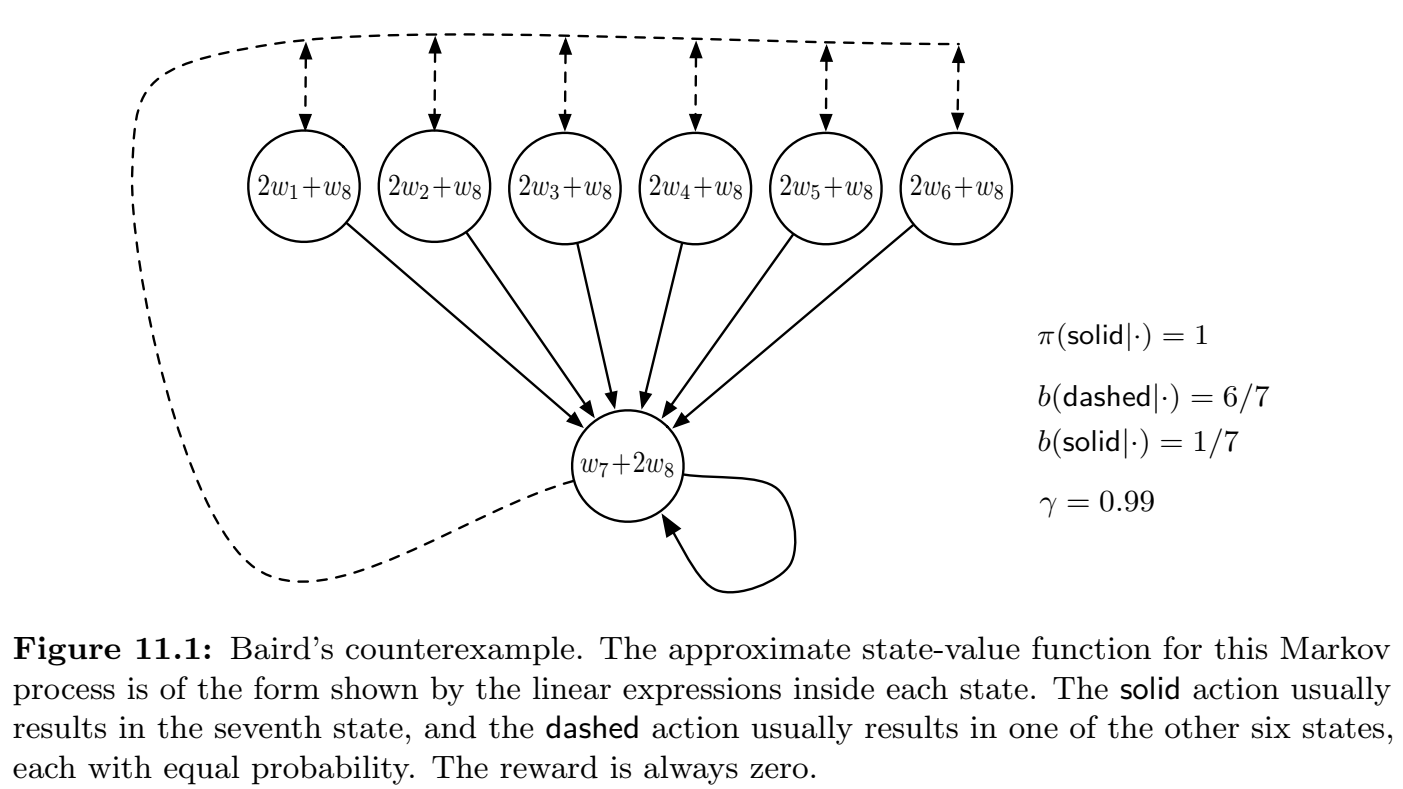

# Packages and helper functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import copy

def V(i, X, w):
    return np.dot(X[i, :],  w)

enum             = lambda x: enumerate(x)
init_matrix      = lambda sz: np.linalg.init_matrix(sz)
copyd            = lambda x: copy.deepcopy(x)

def normal_dist(x , mean , sd):
    prob_density = (np.pi*sd) * np.exp(-0.5*((x-mean)/sd)**2)
    return prob_density

def error_custom(msg):
    raise Exception(msg)

# Tunable Parameters

In [2]:
PARS_default = {
             'sim': 1,
    'N_iterations': 19000,
           'gamma': 0.99,
           'alpha': 0.02,
               'K': 12,
              'w0': np.random.randint(1,10, 8)/1 - 5,
               'b': np.array([1/7, 6/7]),
              'pi': np.array([1,   0]),
              'p8': 1,
            'plot': {'plot_1_1_line_in_target_approx_plot': True} 
    }
p8 = PARS_default['p8']
PARS_default['X'] = np.array([
    [2, 0, 0, 0, 0, 0, 0, p8],
    [0, 2, 0, 0, 0, 0, 0, p8],
    [0, 0, 2, 0, 0, 0, 0, p8],
    [0, 0, 0, 2, 0, 0, 0, p8],
    [0, 0, 0, 0, 2, 0, 0, p8],
    [0, 0, 0, 0, 0, 2, 0, p8],
    [0, 0, 0, 0, 0, 0, 1, 2]
])


# Functions

## Run&Print MDP

In [3]:

def run_MDP(PARS):

    N_iterations = PARS['N_iterations']
    n = 7
    m = 8
    gamma = PARS['gamma']
    alpha = PARS['alpha']
    r = 0
    K = PARS['K']
    w0 = PARS['w0']

    X = PARS['X']

    get_random_state = lambda: np.random.randint(0, n, 1)[0]

    i_0 = get_random_state()
    w = np.linalg.init_matrix([m, N_iterations+1])
    w_m = np.linalg.init_matrix([m, N_iterations+1])

    w[:, 0] = w0
    w_m[:, 0] = w0

    b  = PARS['b']    # behavior policy
    pi = PARS['pi']   # target   policy
    N_actions = len(b)

    if np.sum(b) != 1:
        b[-1] = 1-np.sum(b[:-1])

    target = init_matrix([N_iterations])
    approx = init_matrix([N_iterations])
    delta = init_matrix([N_iterations])

    z = 0
    for t in range(N_iterations):
        # choose index for state
        i1 = get_random_state()
        rho = 0

        p_action = random.uniform(0, 1)

        for i_b, b_i in enumerate(b):
            if p_action <= b_i:
                break

        rho = pi[i_b]/b[i_b]

        if i_b == 0:
            i1 = n
        else:
            i1 = np.random.randint(0, n, 1)[0]

        
        if rho>0:
            target_i = r+gamma*V(i1 - 1, X, w_m[:, t])
            approx_i = V(i_0 - 1, X, w[:, t])
            delta_i = target_i - approx_i
            Dw = X[i_0-1, :] * alpha*rho*delta_i
            w[:, t+1] = w[:, t] + Dw
        else:
            delta_i = 0
            target_i = np.nan
            approx_i = np.nan
            w[:, t+1] = w[:, t]

            
        target[t] = target_i
        approx[t] = approx_i
        delta[t] = delta_i


        i_0 = i1

        if rho > 0: 
            z+=1
            if z % K == 0:
                w_m[:, t+1]=w[:, t+1]
            else:
                w_m[:, t+1]=w_m[:, t]
        else:
            w_m[:, t+1]=w_m[:, t]

    Dw8 = init_matrix([m, N_iterations+1])
    for i in range(N_iterations+1):
        Dw8[:, i] = w[:, i] - w[m-1, i]


    return w, w_m, Dw8, target, approx, delta


def plot_MDP(w, w_m, Dw8, target, approx, delta, PARS):

    n_states = 7
    X = PARS['X']
    N_iterations = PARS['N_iterations']

    plt.rcParams.update({'font.size': 22})
    plt.figure(figsize=(20,12))

    legs = []
    for s in range(n_states):
        plt.plot([i for i in range(N_iterations)], [V(s, X, w[:, i]) for i in range(N_iterations)])
        legs.append(str(s+1))

    
    plt.legend(legs)
    plt.grid()
    plt.xlabel('update step [-]')
    plt.ylabel('V [-]')
    plt.show()


    # plt.plot([i for i in range(N_iterations)], Dw8[1, :-1])
    # plt.grid()
    # plt.show()

    legs = []
    for k in range(8): 
        plt.plot([i for i in range(N_iterations)], w[k, :-1])
        legs.append(str(k+1))
    
    plt.legend(legs)
    plt.grid()
    plt.xlabel('update step [-]')
    plt.ylabel('w [-]')
    plt.show()


    plt.plot(target, approx, '.')

    if PARS['plot']['plot_1_1_line_in_target_approx_plot']:
        
        target_h = np.array([tar for tar in target if not np.isnan(tar)])
        approx_h = np.array([tar for tar in approx if not np.isnan(tar)])

        if np.max(np.abs(target_h))>np.max(np.abs(approx_h)):
            mab1 = np.max(np.abs(target_h))
            idx1 = [i for i, p in enum(target_h) if np.abs(p)==mab1]
            yPts = [0, target_h[idx1[0]]]

        else:
            mab1 = np.max(np.abs(approx_h))
            idx1 = [i for i, p in enum(approx_h) if np.abs(p)==mab1]
            yPts = [0, approx_h[idx1[0]]]

        plt.plot(yPts, yPts)
        


    plt.grid()
    plt.xlabel('target [-]')
    plt.ylabel('approximation [-]')

    plt.show()


    plt.plot([i for i in range(N_iterations)], delta)
    plt.grid()
    plt.xlabel('update step [-]')
    plt.ylabel('$\delta$ [-]')

    plt.show()


    plt.plot([i for i in range(N_iterations)], approx)
    plt.grid()    
    plt.xlabel('update step [-]')
    plt.ylabel('approximation [-]')

    plt.show()



    

## Print-Table

In [49]:
def print_table(data, transpose=False):
    if len(data) == 0:
        print("No data to display.")
        return

    # Extract the keys from the first dictionary
    headers = list(data['1'].keys())


    data_1 = []

    for h in data.keys():
        data_1.append(data[h])

    if transpose:
        # Transpose the data
        data_1 = [{key: value for key, value in zip(data_1[0].keys(), values)} for values in zip(*[d.values() for d in data_1])]


    # Determine the dimensions of the table
    num_rows = len(data)
    num_cols = len(headers)

    if True:

        # Calculate the maximum width of each column
        col_widths = {}

        for header in headers:
            values = [d.get(header) for d in data_1]
            if all(isinstance(v, np.ndarray) for v in values):
                col_widths[header] = max(len(str(header)), max(len(str(v)) for v in values))
            else:
                col_widths[header] = max(len(str(header)), max(len(str(d.get(header, ""))) for d in data_1))

        # Print the headers
        print("| " + "|".join(f"{header:^{col_widths[header]}}" for header in headers)+" |")
        print("|" + "|".join("-" * col_widths[header] for header in headers)+"|")

        # Print the data
        for d in data_1:
            for header in headers:
                value = d.get(header, '')
                if isinstance(value, np.ndarray):
                    value_str = str(value).replace('\n', '')
                    print(f"{value_str:^{col_widths[header]}}", end=" | ")
                else:
                    try:
                        print(f"{value:^{col_widths[header]}}", end=" | ")
                    except:
                        dd=1 # just do nothing

            print()





    else:
        # Transpose the table
        transposed_data = [{headers[j]: data_1[i].get(headers[j], '') for j in range(num_cols)} for i in range(num_rows)]

        # Calculate the maximum width of each column
        col_widths = {}
        for header in headers:
            col_widths[header] = max(len(str(header)), max(len(str(d.get(header, ""))) for d in transposed_data))

        # Print the headers
        for header in headers:
            print(f"{header:^{col_widths[header]}}", end=" ")
        print()

        # Print the data
        for d in transposed_data:
            for header in headers:
                value = d.get(header, '')
                if isinstance(value, np.ndarray):
                    value_str = str(value).replace('\n', '')
                    print(f"{value_str:^{col_widths[header]}}", end=" ")
                else:
                    print(f"{value:^{col_widths[header]}}", end=" ")
            print()


# Parameter Studies

## Initialize

In [5]:
PARS = dict()
SIGS = dict()
PERFORMANCE_INDEX = dict()

## Performance Indexes

- Convergence Rate
    1. Low
    2. Medium
    3. High
    4.  Does not converge
- Correlation between update and approximation
    1. Starts high, ends 0
    2. 0
    3. High


In [6]:
ID__INDEX__CONVERGENCE_RATE__LOW                            = 'Low'
ID__INDEX__CONVERGENCE_RATE__EXTREMELY_LOW                  = 'Extremely Low'
ID__INDEX__CONVERGENCE_RATE__MEDIUM                         = 'Medium'
ID__INDEX__CONVERGENCE_RATE__HIGH                           = 'High'
ID__INDEX__CONVERGENCE_RATE__DOES_NOT_CONVERGE              = 'No Convergence'

ID__INDEX__CORRELATION_UPDATE_APPROX__STARTS_HIGH_ENDS_ZERO = 'starts high, ends at 0'
ID__INDEX__CORRELATION_UPDATE_APPROX__ZERO                  = '0'
ID__INDEX__CORRELATION_UPDATE_APPROX__HIGH                  = 'High'

ID__INDEX__APPROXIMATION_ACCURACY__LOW                      = 'Low'
ID__INDEX__APPROXIMATION_ACCURACY__HIGH                     = 'High'
ID__INDEX__APPROXIMATION_ACCURACY__NOT_APPL                 = 'N/A'


PERFORMANCE_INDEX_DEFAULT = {
                                             'sim': 1,
                                'convergence_rate': ID__INDEX__CONVERGENCE_RATE__DOES_NOT_CONVERGE,
    'correlation between update and approximation': ID__INDEX__CORRELATION_UPDATE_APPROX__STARTS_HIGH_ENDS_ZERO,
                          'approximation accuracy': ID__INDEX__APPROXIMATION_ACCURACY__LOW
    }

## 1

In [7]:
sim_index = 1

PARS[str(sim_index)] = copyd(PARS_default)
PARS[str(sim_index)]['sim'] = sim_index

SIGS[str(sim_index)] = run_MDP(PARS[str(sim_index)])

### Plots

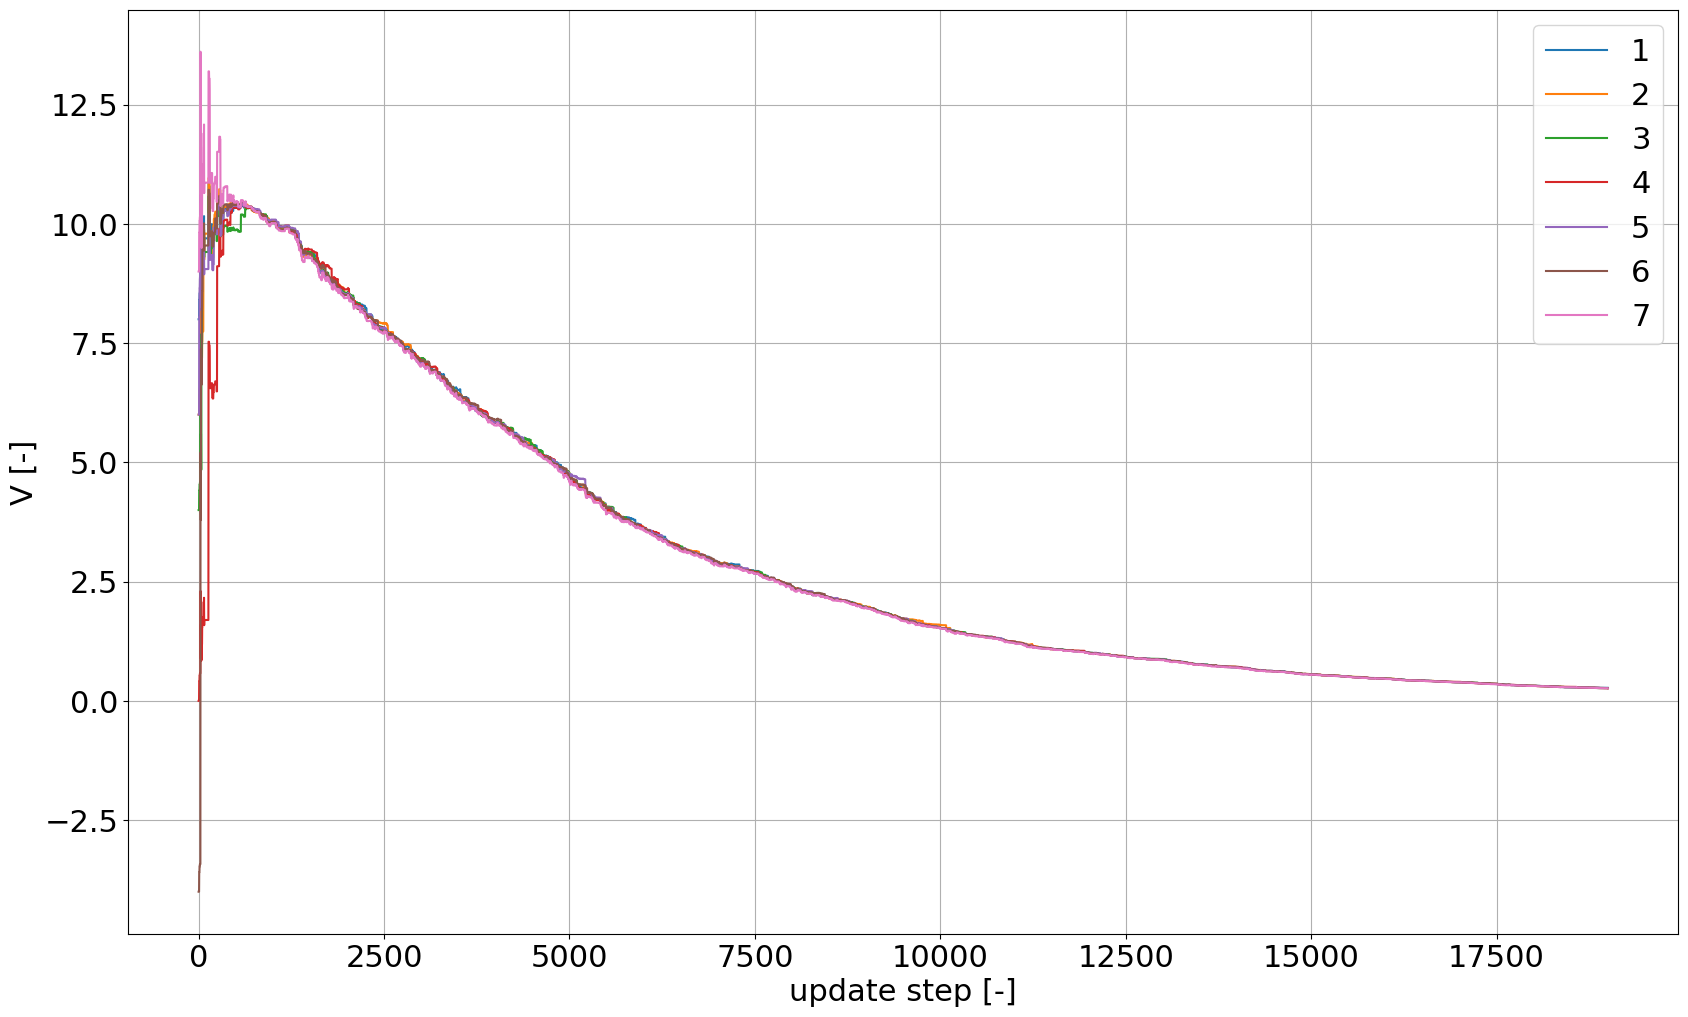

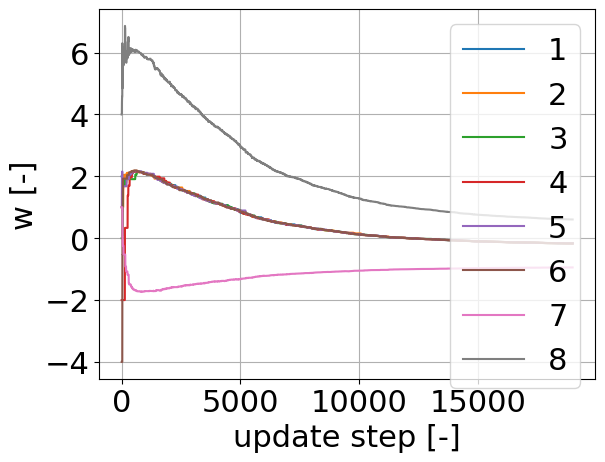

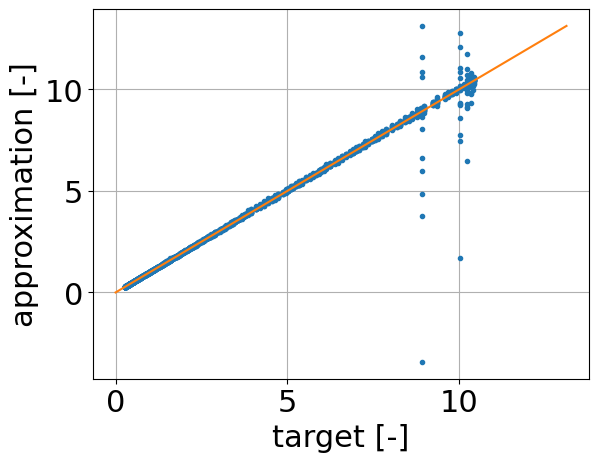

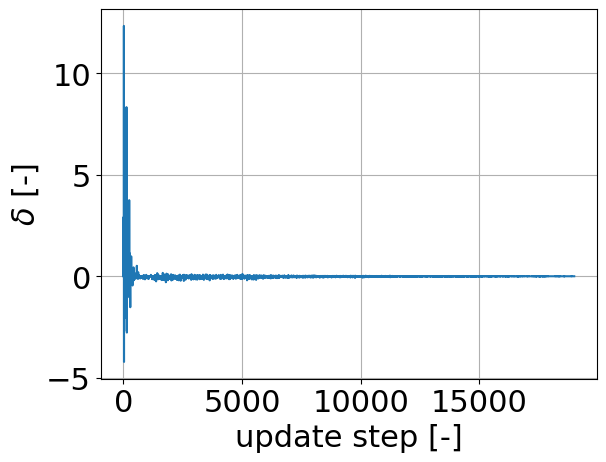

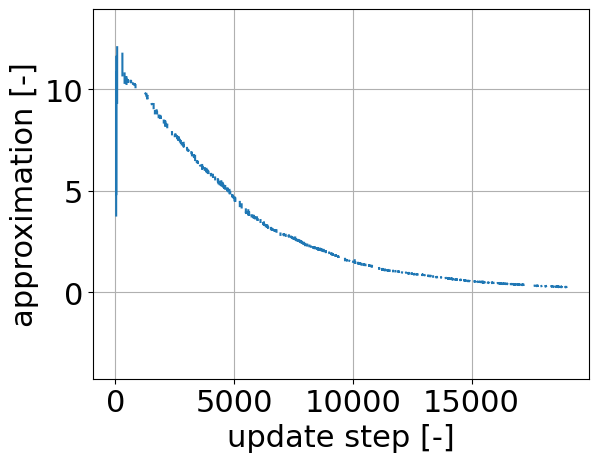

In [8]:
w, w_m, Dw8, target, approx, delta = SIGS[str(sim_index)]
plot_MDP(w, w_m, Dw8, target, approx, delta, PARS[str(sim_index)])

### 💭

- Slow convergence


In [9]:
sim_index = 1 
PERFORMANCE_INDEX[str(sim_index)] = copyd(PERFORMANCE_INDEX_DEFAULT)
PERFORMANCE_INDEX[str(sim_index)]['sim'] = sim_index

PERFORMANCE_INDEX[str(sim_index)]['convergence_rate'] = ID__INDEX__CONVERGENCE_RATE__LOW

PERFORMANCE_INDEX[str(sim_index)]['correlation between update and approximation'] = ID__INDEX__CORRELATION_UPDATE_APPROX__HIGH


PERFORMANCE_INDEX[str(sim_index)]['approximation accuracy'] = ID__INDEX__APPROXIMATION_ACCURACY__HIGH

## 2
What happens if we do not use the additional set of parameters?

In [10]:
sim_index = 2

PARS[str(sim_index)]  = copyd(PARS_default)
PARS_C = {
             'sim': sim_index,
               'K': 1,
              'w0': np.random.randint(1,10, 8)/1 - 5,
    'N_iterations': 10000
}

PARS[str(sim_index)] |= PARS_C

SIGS[str(sim_index)]  = run_MDP(PARS[str(sim_index)])


#### Plots

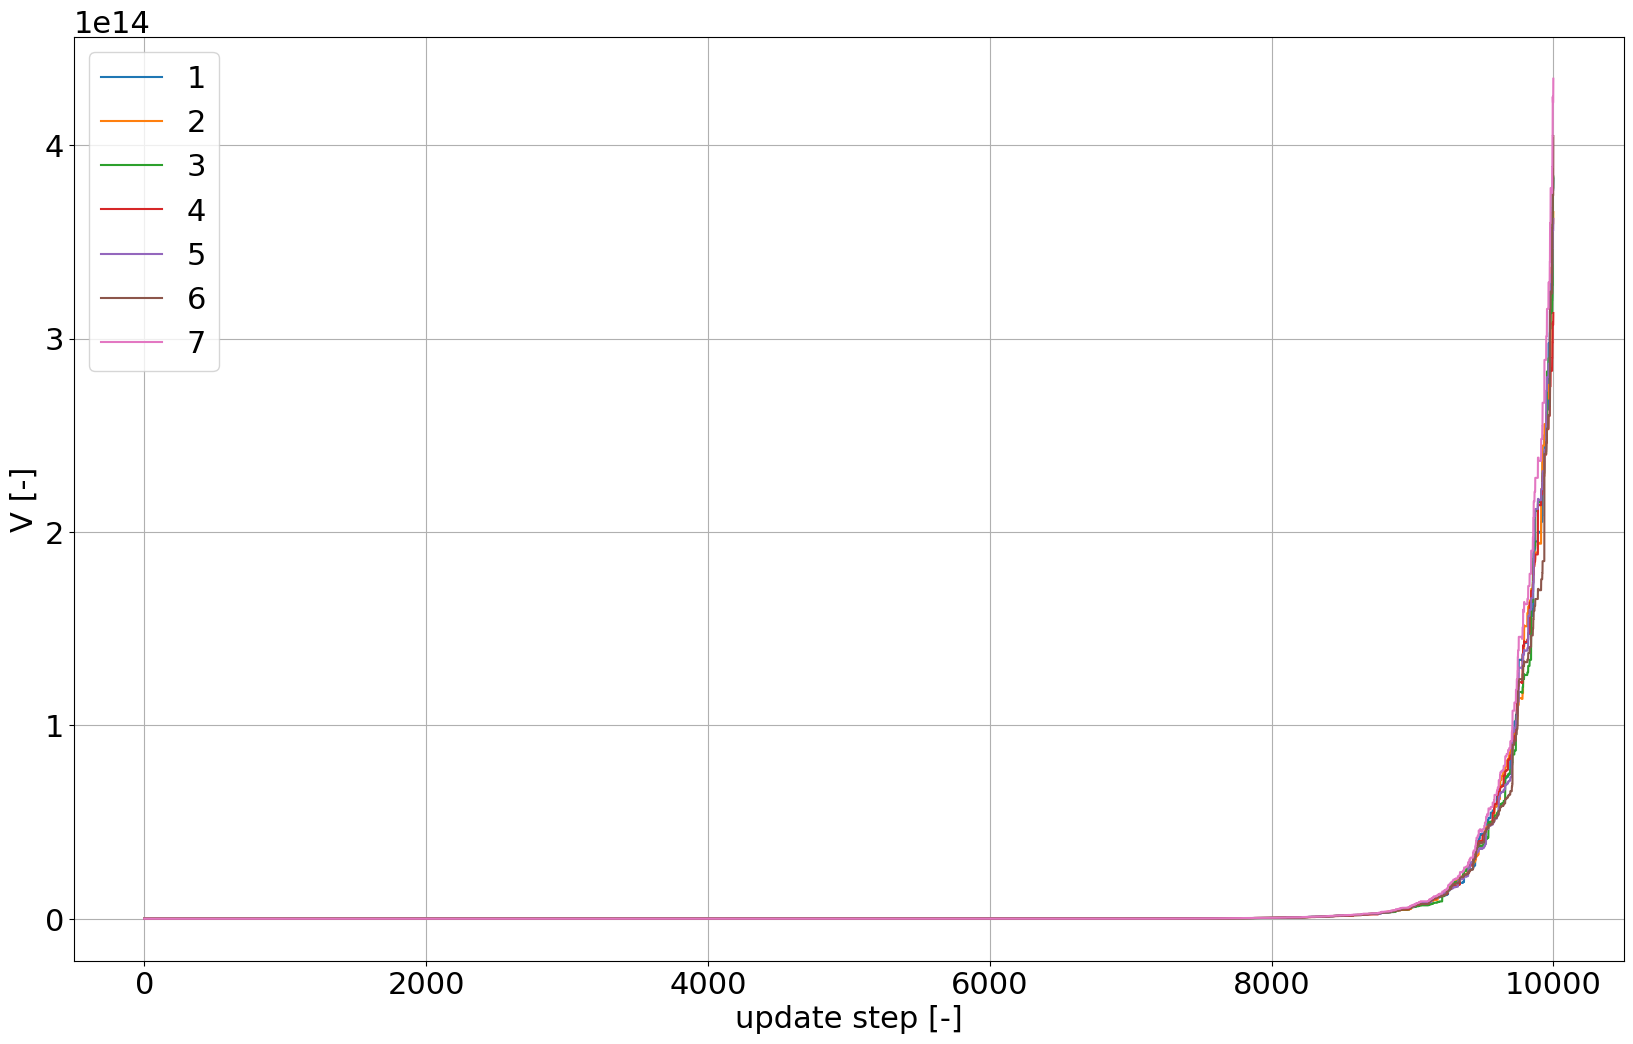

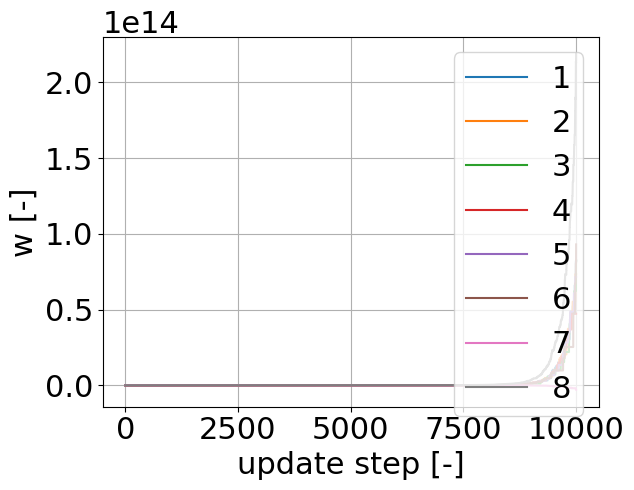

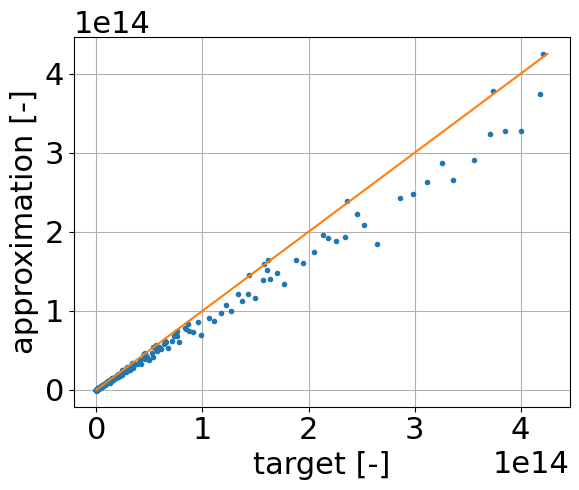

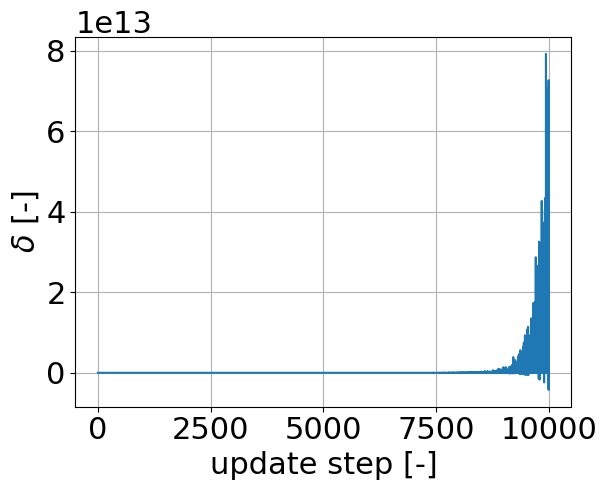

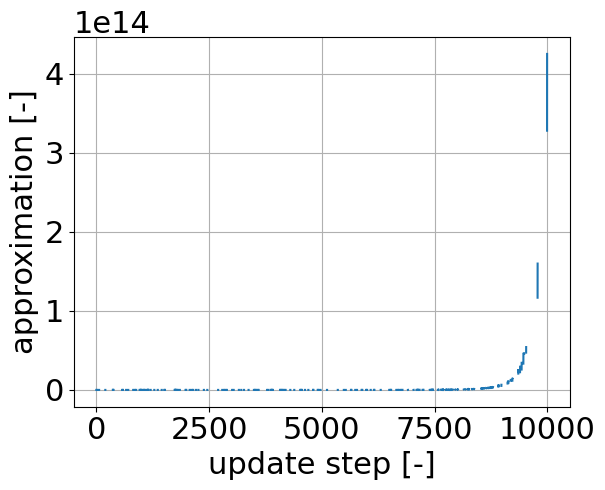

In [11]:
w, w_m, Dw8, target, approx, delta = SIGS[str(sim_index)]
plot_MDP(w, w_m, Dw8, target, approx, delta, PARS[str(sim_index)])

### Some Analysis

In [52]:
w=w.transpose()

In [53]:
# Some analysis

# w, w_m, Dw8, target, approx, delta

update_index = []
w0 = w[0, :]

for i, wi in enum(w[1:]):
    Dw=wi-w0
    idx1 = [i for i, Dwi in enum(Dw) if Dwi!=0 and i!=7]
    if len(idx1)>0:
        update_index.append([i, idx1[0]])

    w0=wi
    
print('')

#### Tabulate

In [54]:
# for idx in update_index:

import pandas as pd
from tabulate import tabulate


alpha1=PARS['2']['alpha']*7
X = PARS['2']['X']
results = [
        [
        delta[idx[0]],
        2*alpha1*delta[idx[0]],
        5*alpha1*delta[idx[0]]*(idx[1]==1) + alpha1*delta[idx[0]]*(idx[1]!=1),
        target[idx[0]], 
        approx[idx[0]], 
        idx[1]+1,
        V(1-1, X, w[idx[0], :]),
        V(2-1, X, w[idx[0], :]),
        V(3-1, X, w[idx[0], :]),
        V(4-1, X, w[idx[0], :]),
        V(5-1, X, w[idx[0], :]),
        V(6-1, X, w[idx[0], :]),
        V(7-1, X, w[idx[0], :])
        ] 
        for idx in update_index
    ]

labels = ["Delta", "Increment-7", "Increament-2", "Target", "Approx", "Index",\
                                  "V_1", "V_2", "V_3", "V_4", "V_5", "V_6", "V_7"]

print(tabulate(results, headers=labels))



# assuming `results` is a list of lists or a 2D numpy array

# create a DataFrame from the `results` list
df = pd.DataFrame(results, columns=["Delta", "Increment-7", "Increament-2", "Target", "Approx", "Index", "V_1", "V_2", "V_3", "V_4", "V_5", "V_6", "V_7"])

# write the DataFrame to an Excel file
with pd.ExcelWriter('output.xlsx') as writer:
    df.to_excel(writer, index=False, sheet_name='Sheet1')

# print the tabulated results to the console
print(tabulate(results, headers=labels))



       Delta    Increment-7    Increament-2     Target       Approx    Index        V_1        V_2          V_3         V_4         V_5          V_6        V_7
------------  -------------  --------------  ---------  -----------  -------  ---------  ---------  -----------  ----------  ----------  -----------  ---------
-0.05          -0.014          -0.007         4.95       5                 7   9         11          9           11          -3          11            5
-4.036         -1.13008        -0.56504       4.95       8.986             3   8.986     10.986      8.986       10.986      -3.014      10.986        4.965
-5.47096       -1.53187        -0.765934      4.95      10.421             6   8.42096   10.421      6.1608      10.421      -3.57904    10.421        3.83492
-4.70503       -1.31741        -0.658704      4.95       9.65503           4   7.65503    9.65503    5.39487      9.65503    -4.34497     6.59129      2.30305
-2.04632       -0.57297        -0.286485      4.95  

### 💭
Now we can see that:

- Correlation between update and target exists. 
- The distance from the 1:1 line increases, which is expected (see what I wrote in SN). The target is always larger than the approximation, which is expected

Note: depending on the different initial conditions and random selections of actions, the value function estimation can be either positive or negative

In [12]:
sim_index = 2 
PERFORMANCE_INDEX[str(sim_index)] = copyd(PERFORMANCE_INDEX_DEFAULT)
PERFORMANCE_INDEX[str(sim_index)]['sim'] = sim_index
PERFORMANCE_INDEX[str(sim_index)]['convergence_rate'] = ID__INDEX__CONVERGENCE_RATE__DOES_NOT_CONVERGE

PERFORMANCE_INDEX[str(sim_index)]['correlation between update and approximation'] =\
      ID__INDEX__CORRELATION_UPDATE_APPROX__HIGH
PERFORMANCE_INDEX[str(sim_index)]['approximation accuracy'] = ID__INDEX__APPROXIMATION_ACCURACY__NOT_APPL

## 3
We believe that the reason for the instabilities is the choice of including $w_{8}$ inside the value function approximation of every state. If instead we were to not include it, we would have something else.

In [13]:
sim_index = 3


PARS[str(sim_index)]  = copyd(PARS_default)
PARS[str(sim_index)]['sim'] = sim_index
PARS[str(sim_index)]['K'] = 1
PARS[str(sim_index)]['N_iterations'] = 1000
PARS[str(sim_index)]['p8'] = -1
p8 = PARS[str(sim_index)]['p8']
PARS[str(sim_index)]['X'] = np.array([
    [2, 0, 0, 0, 0, 0, 0, p8],
    [0, 2, 0, 0, 0, 0, 0, p8],
    [0, 0, 2, 0, 0, 0, 0, p8],
    [0, 0, 0, 2, 0, 0, 0, p8],
    [0, 0, 0, 0, 2, 0, 0, p8],
    [0, 0, 0, 0, 0, 2, 0, p8],
    [0, 0, 0, 0, 0, 0, 1, 2]
])



SIGS[str(sim_index)]  = run_MDP(PARS[str(sim_index)])


### Plots

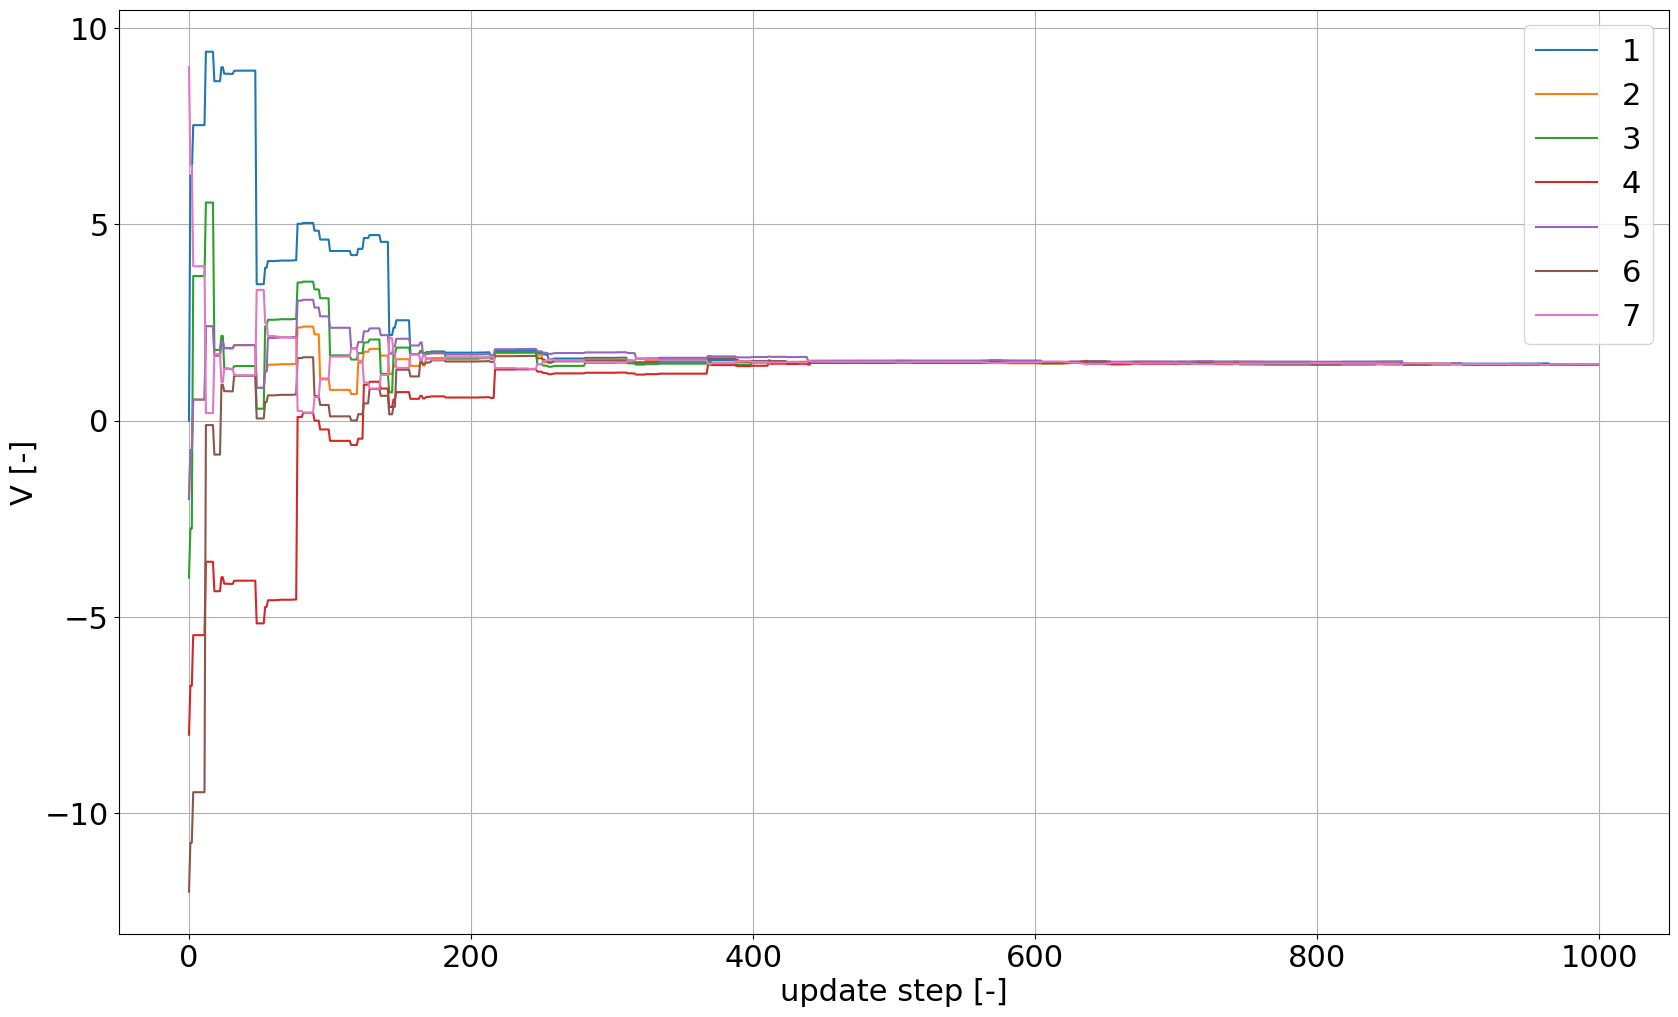

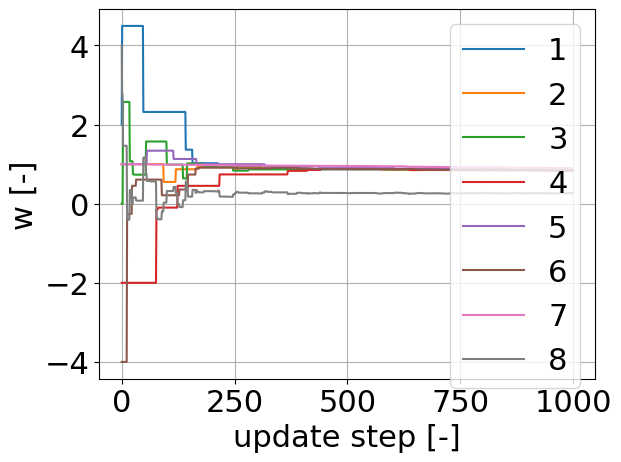

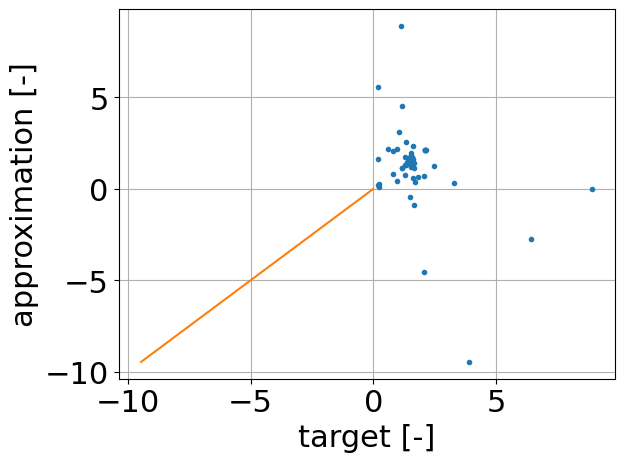

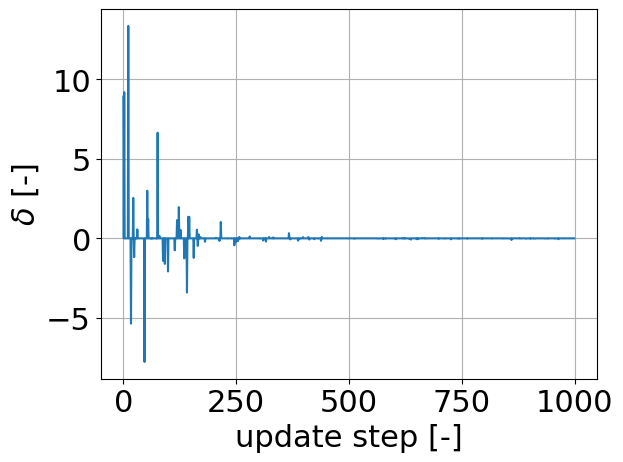

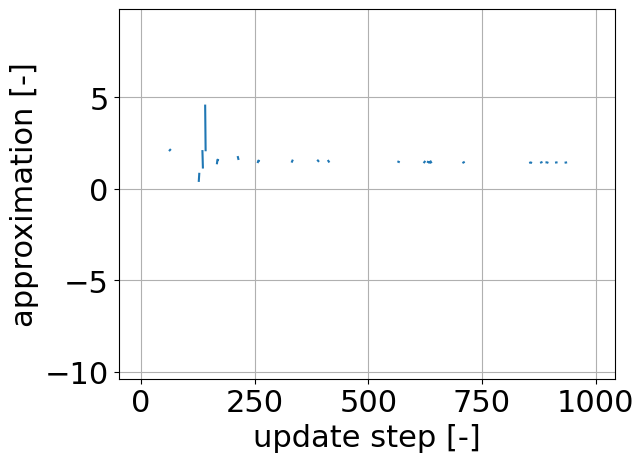

In [14]:
w, w_m, Dw8, target, approx, delta = SIGS[str(sim_index)]
plot_MDP(w, w_m, Dw8, target, approx, delta, PARS[str(sim_index)])

### 💭

- Convergence rate: High

In [15]:
sim_index = 3 
PERFORMANCE_INDEX[str(sim_index)] = copyd(PERFORMANCE_INDEX_DEFAULT)
PERFORMANCE_INDEX[str(sim_index)]['sim'] = sim_index
PERFORMANCE_INDEX[str(sim_index)]['convergence_rate'] = ID__INDEX__CONVERGENCE_RATE__HIGH

PERFORMANCE_INDEX[str(sim_index)]['correlation between update and approximation'] =\
     ID__INDEX__CORRELATION_UPDATE_APPROX__ZERO
PERFORMANCE_INDEX[str(sim_index)]['approximation accuracy'] = ID__INDEX__APPROXIMATION_ACCURACY__LOW

## 4

In [16]:
sim_index = 4


PARS[str(sim_index)]  = copyd(PARS_default)
PARS[str(sim_index)]['sim'] = sim_index
PARS[str(sim_index)]['K'] = 1
PARS[str(sim_index)]['N_iterations'] = 20000
PARS[str(sim_index)]['p8'] = 0
p8 = PARS[str(sim_index)]['p8']
PARS[str(sim_index)]['X'] = np.array([
    [2, 0, 0, 0, 0, 0, 0, p8],
    [0, 2, 0, 0, 0, 0, 0, p8],
    [0, 0, 2, 0, 0, 0, 0, p8],
    [0, 0, 0, 2, 0, 0, 0, p8],
    [0, 0, 0, 0, 2, 0, 0, p8],
    [0, 0, 0, 0, 0, 2, 0, p8],
    [0, 0, 0, 0, 0, 0, 1, 2]
])

SIGS[str(sim_index)]  = run_MDP(PARS[str(sim_index)])


### Plots

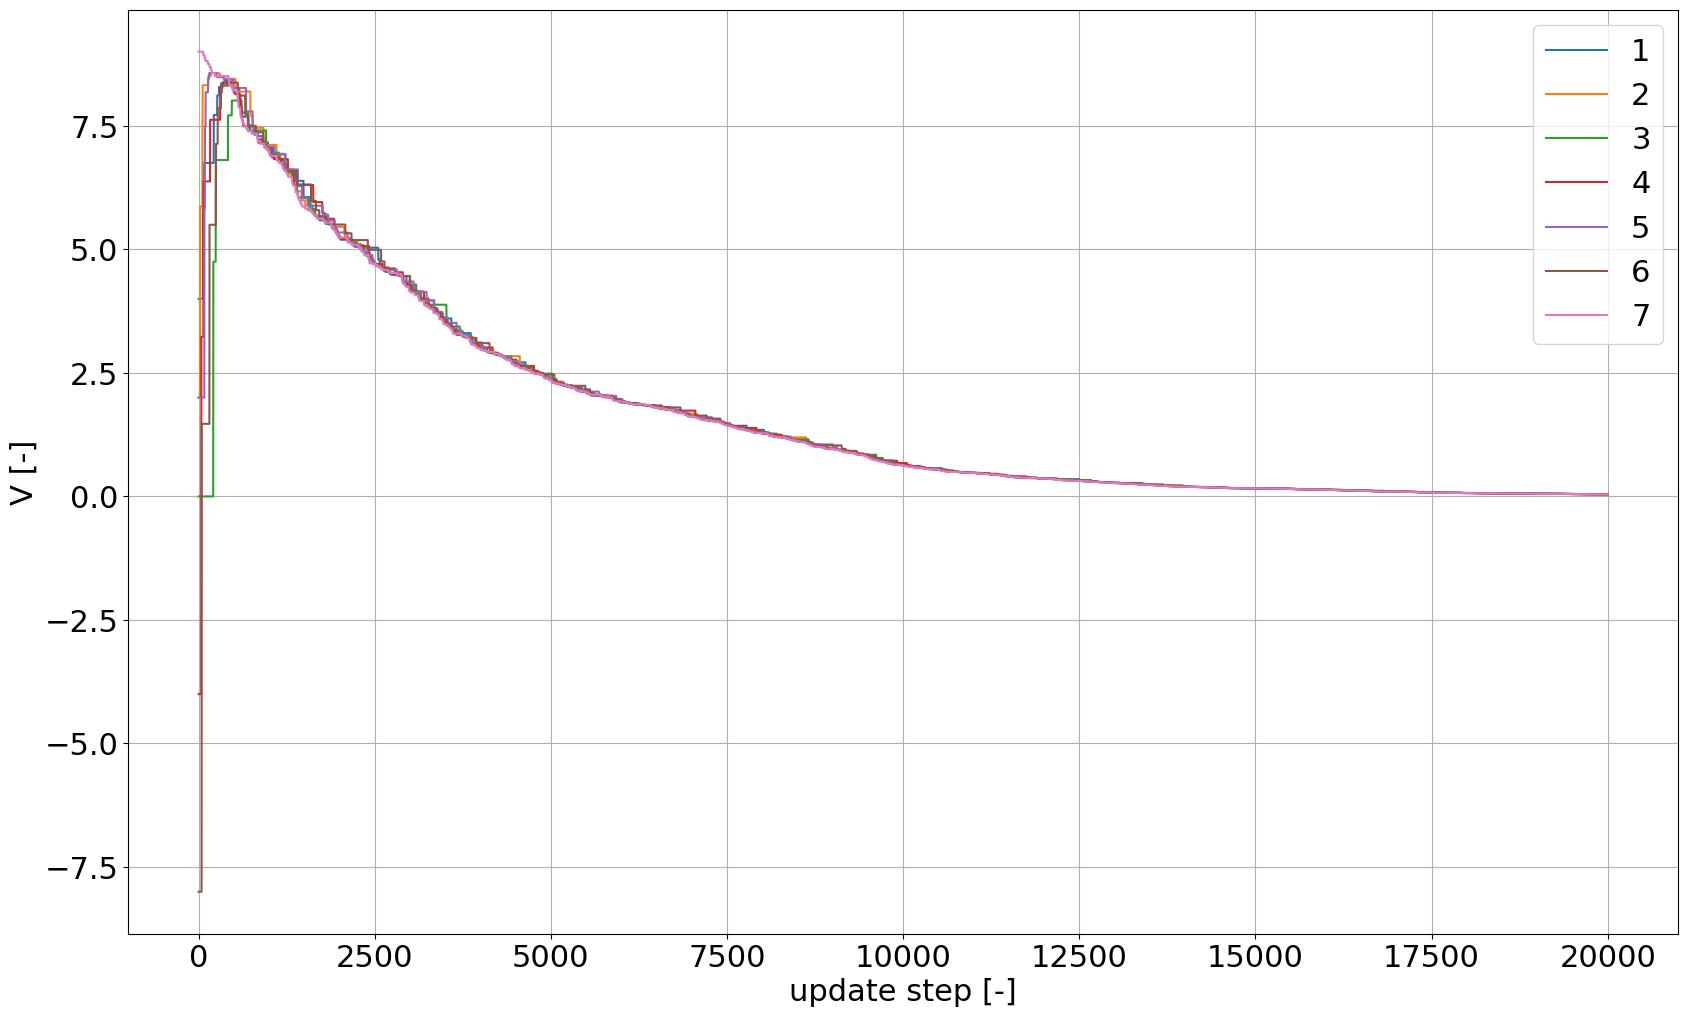

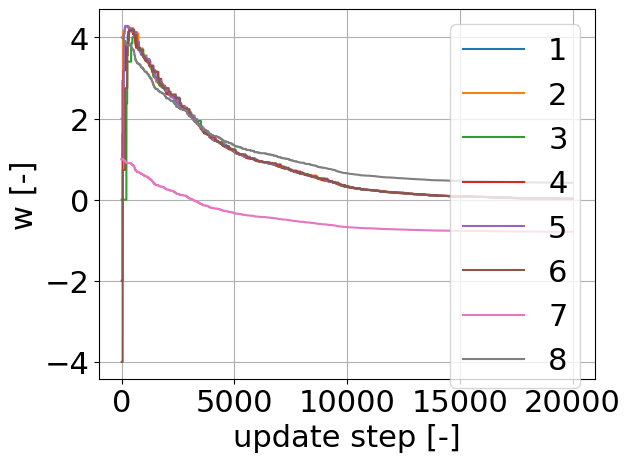

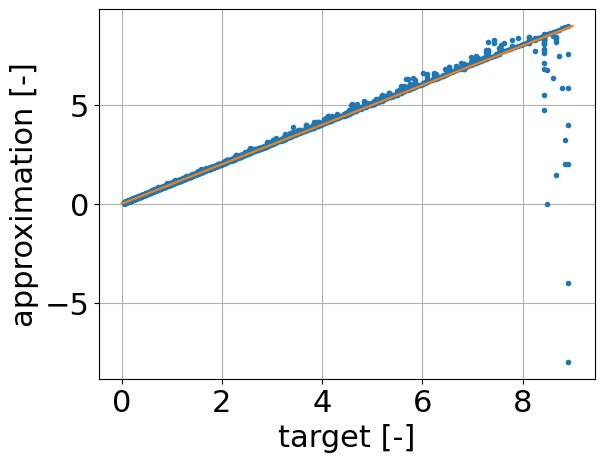

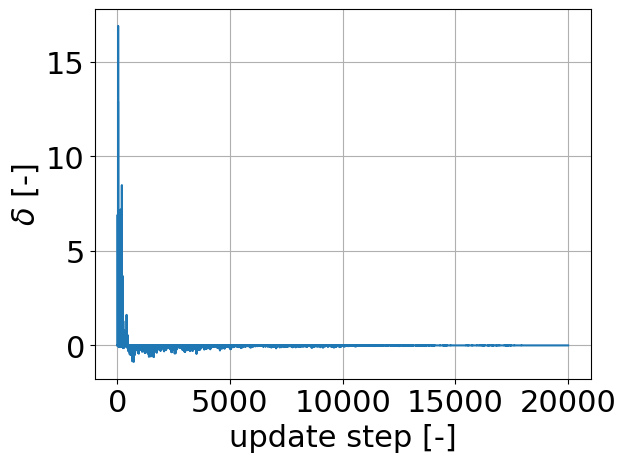

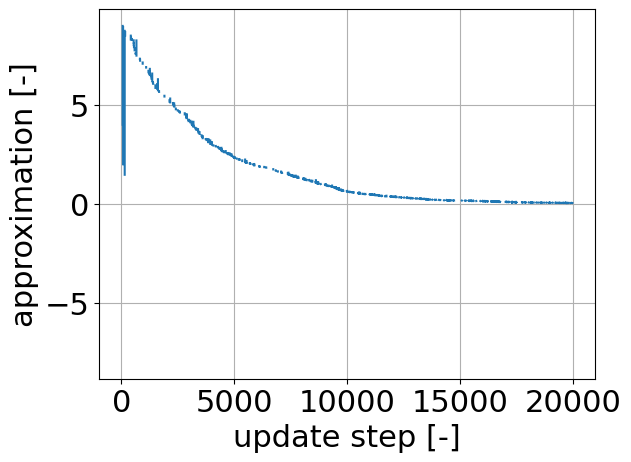

In [17]:
w, w_m, Dw8, target, approx, delta = SIGS[str(sim_index)]
plot_MDP(w, w_m, Dw8, target, approx, delta, PARS[str(sim_index)])

### 💭

- Convergence is slower

In [18]:
sim_index = 4 
PERFORMANCE_INDEX[str(sim_index)] = copyd(PERFORMANCE_INDEX_DEFAULT)
PERFORMANCE_INDEX[str(sim_index)]['sim'] = sim_index
PERFORMANCE_INDEX[str(sim_index)]['convergence_rate'] = ID__INDEX__CONVERGENCE_RATE__LOW

PERFORMANCE_INDEX[str(sim_index)]['correlation between update and approximation'] =\
    '?'
PERFORMANCE_INDEX[str(sim_index)]['approximation accuracy'] = ID__INDEX__APPROXIMATION_ACCURACY__HIGH

## 5

In [19]:
sim_index = 5

PARS[str(sim_index)] = copyd(PARS_default)
PARS[str(sim_index)]['sim'] = sim_index
PARS[str(sim_index)]['K'] = 6

SIGS[str(sim_index)] = run_MDP(PARS[str(sim_index)])

### Plots

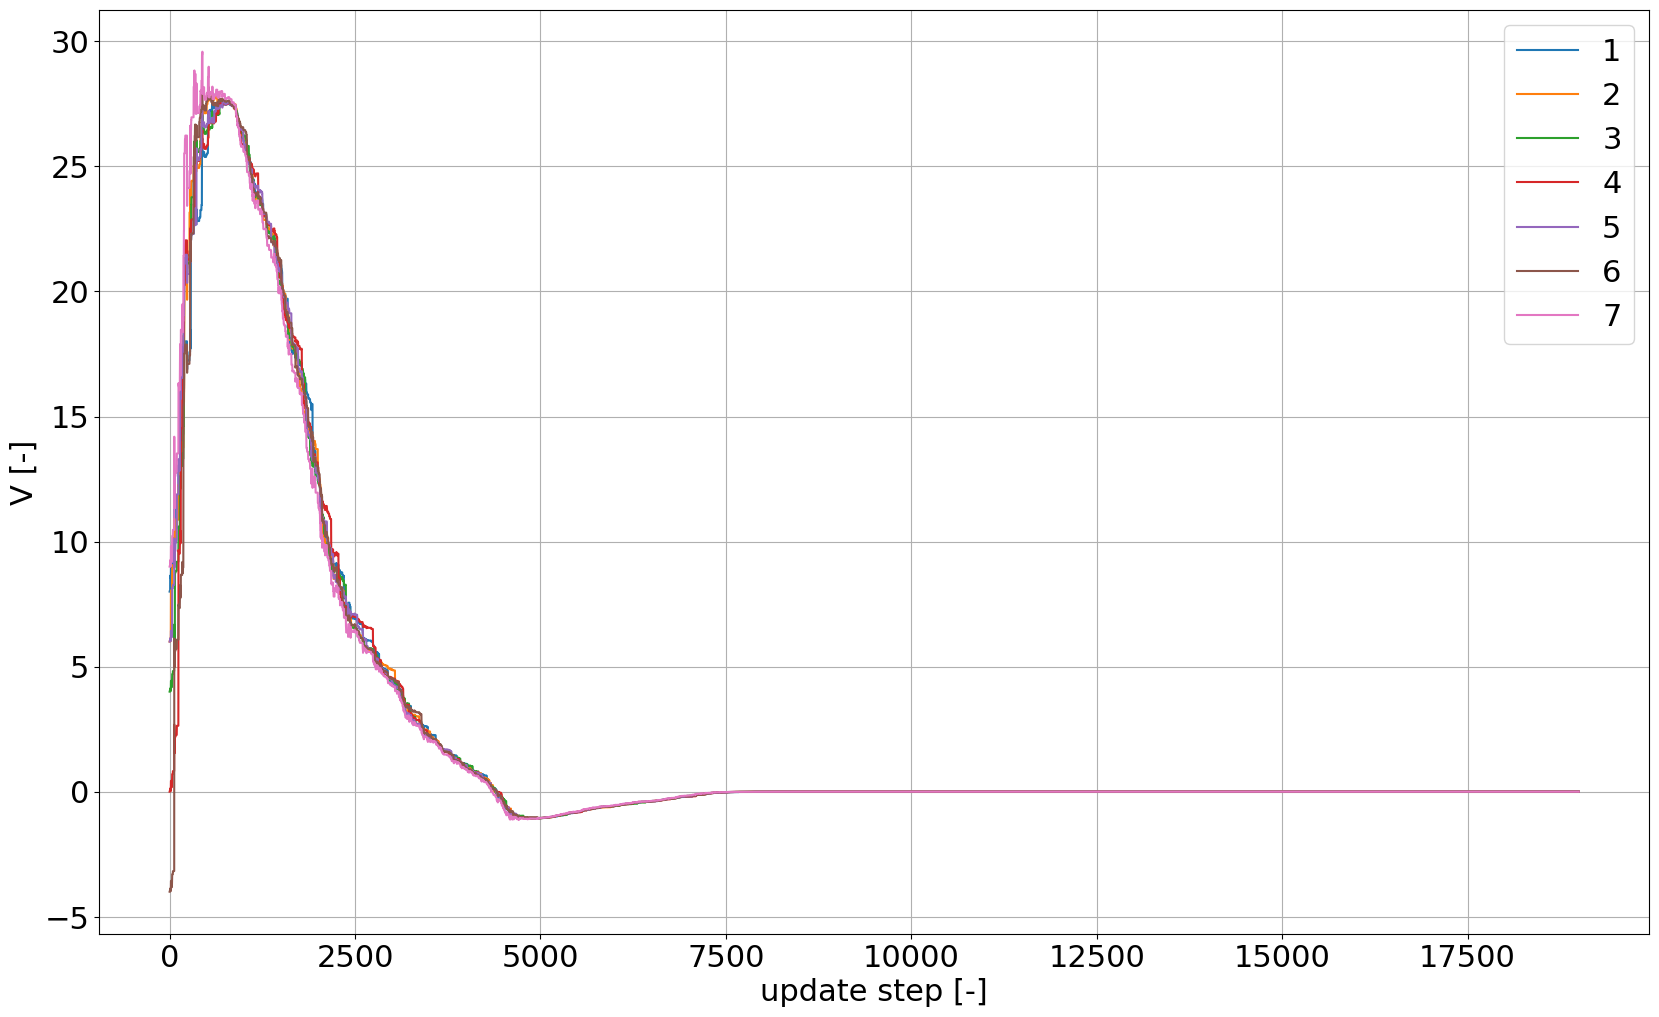

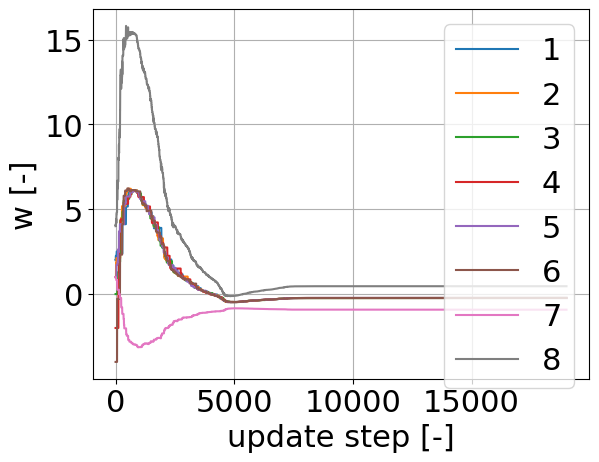

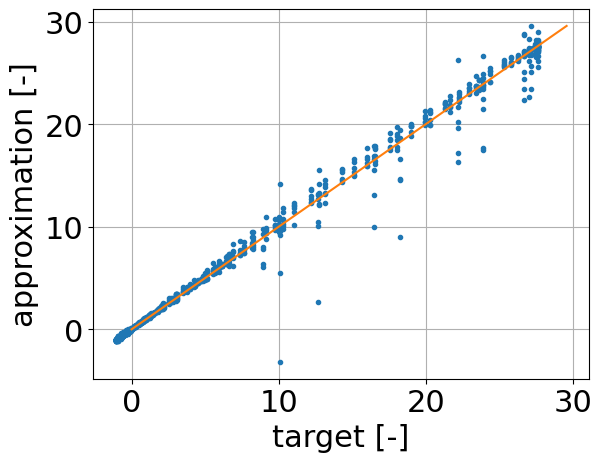

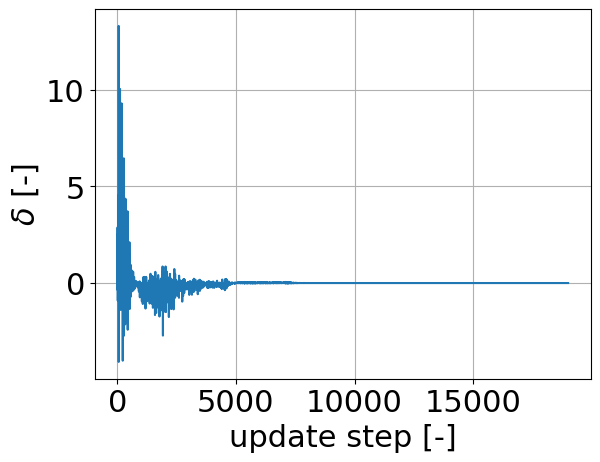

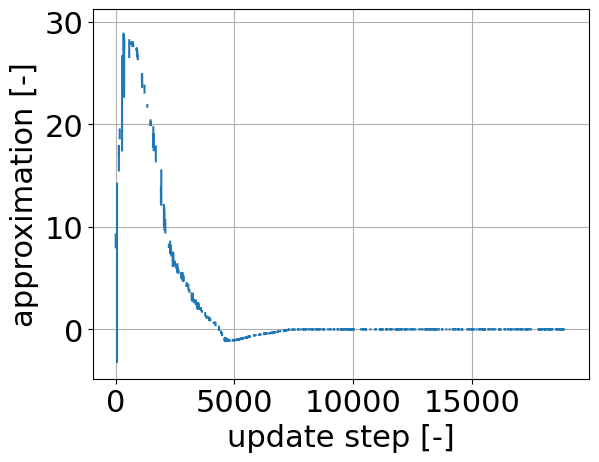

In [20]:
w, w_m, Dw8, target, approx, delta = SIGS[str(sim_index)]
plot_MDP(w, w_m, Dw8, target, approx, delta, PARS[str(sim_index)])

### 💭

In [21]:
sim_index = 5 
PERFORMANCE_INDEX[str(sim_index)] = copyd(PERFORMANCE_INDEX_DEFAULT)
PERFORMANCE_INDEX[str(sim_index)]['sim'] = sim_index
PERFORMANCE_INDEX[str(sim_index)]['convergence_rate'] = ID__INDEX__CONVERGENCE_RATE__HIGH

PERFORMANCE_INDEX[str(sim_index)]['correlation between update and approximation'] = \
ID__INDEX__CORRELATION_UPDATE_APPROX__HIGH
PERFORMANCE_INDEX[str(sim_index)]['approximation accuracy'] = ID__INDEX__APPROXIMATION_ACCURACY__HIGH

## 6

In [22]:
sim_index = 6

PARS[str(sim_index)] = copyd(PARS_default)
PARS[str(sim_index)]['sim'] = sim_index
PARS[str(sim_index)]['K'] = 3

SIGS[str(sim_index)] = run_MDP(PARS[str(sim_index)])

### Plots

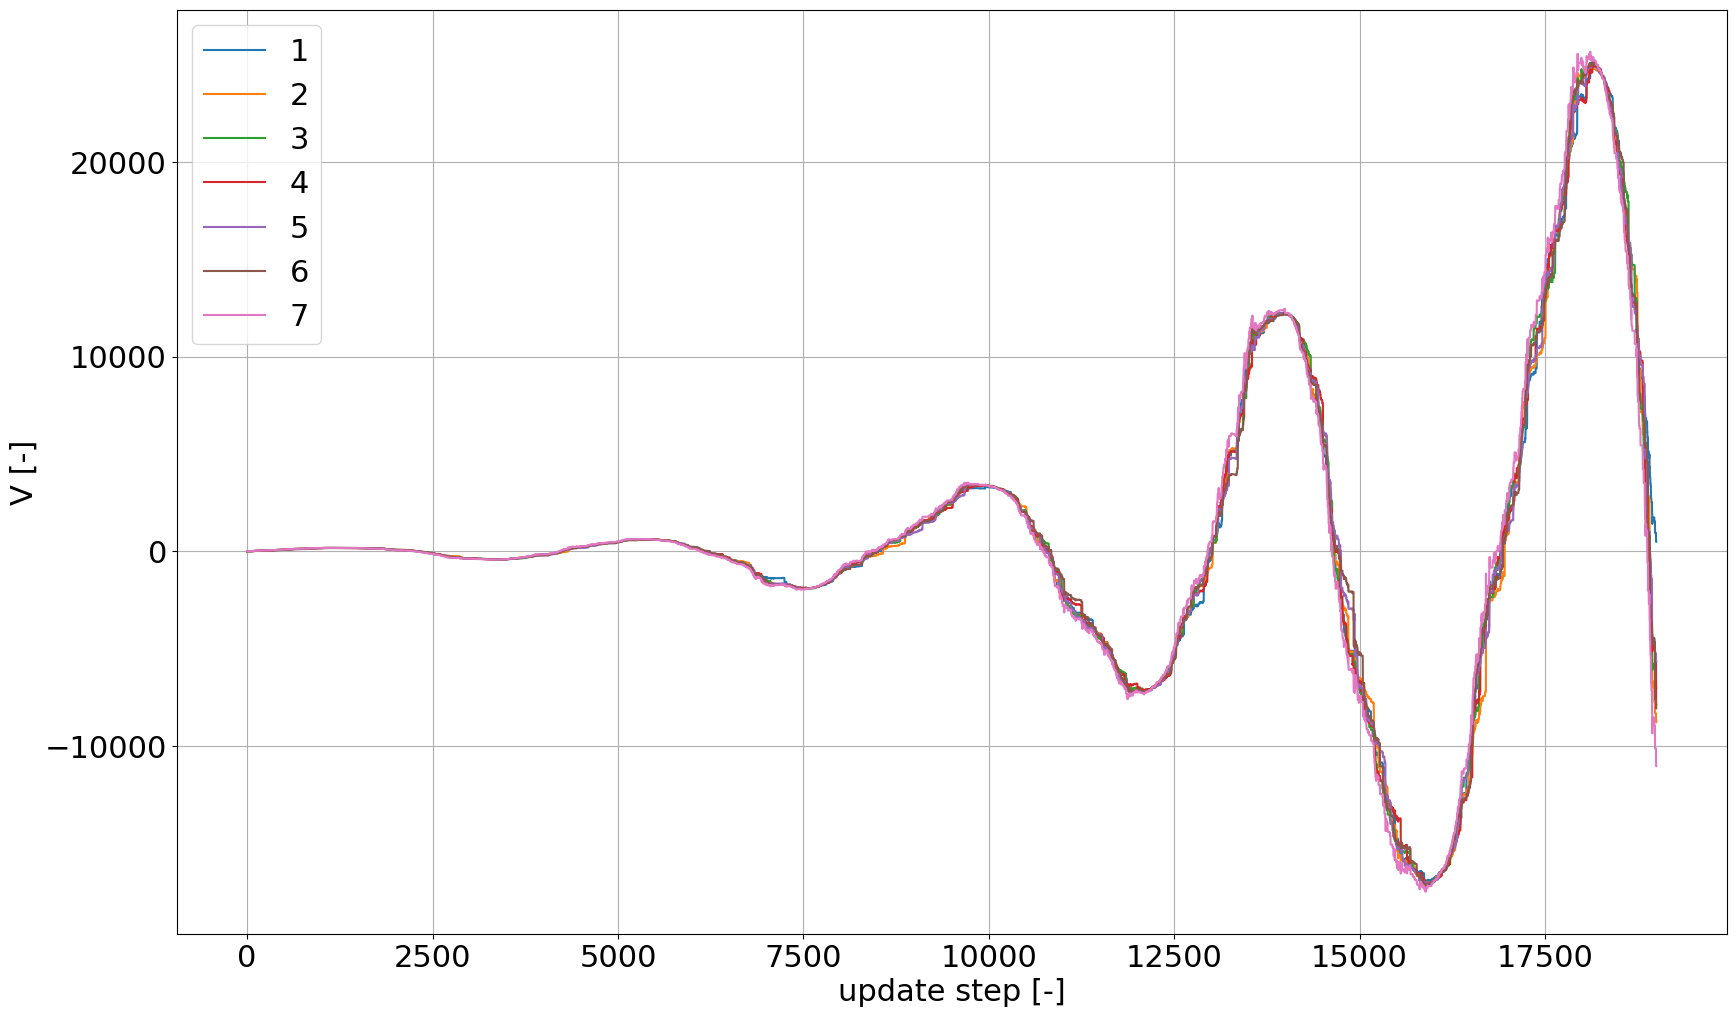

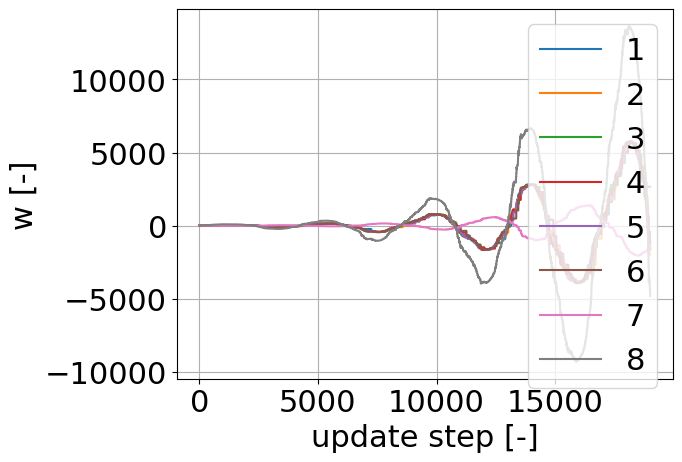

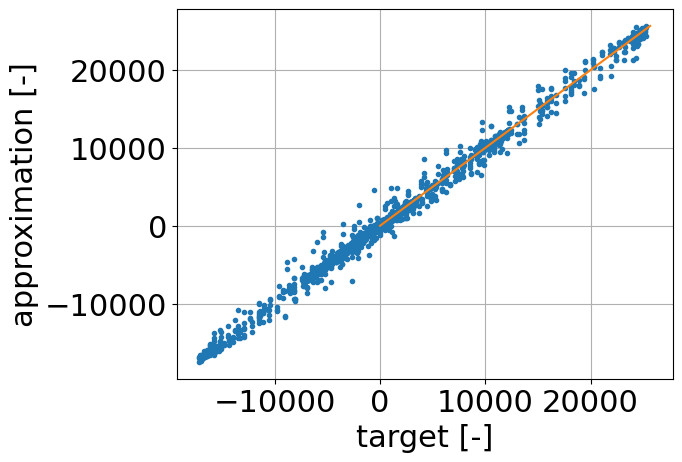

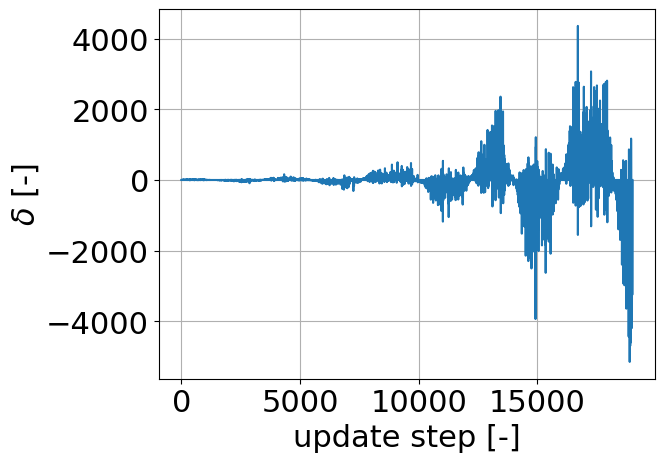

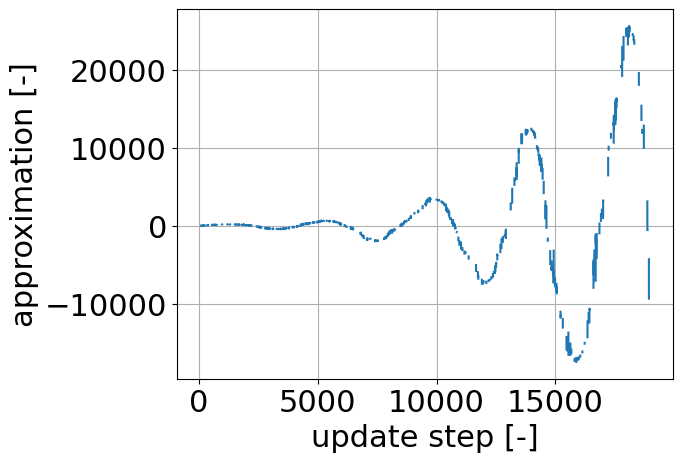

In [23]:
w, w_m, Dw8, target, approx, delta = SIGS[str(sim_index)]
plot_MDP(w, w_m, Dw8, target, approx, delta, PARS[str(sim_index)])

### 💭

In [24]:
sim_index = 6 
PERFORMANCE_INDEX[str(sim_index)] = copyd(PERFORMANCE_INDEX_DEFAULT)
PERFORMANCE_INDEX[str(sim_index)]['sim'] = sim_index
PERFORMANCE_INDEX[str(sim_index)]['convergence_rate'] = ID__INDEX__CONVERGENCE_RATE__DOES_NOT_CONVERGE

PERFORMANCE_INDEX[str(sim_index)]['correlation between update and approximation'] =\
      ID__INDEX__CORRELATION_UPDATE_APPROX__HIGH
PERFORMANCE_INDEX[str(sim_index)]['approximation accuracy'] = ID__INDEX__APPROXIMATION_ACCURACY__NOT_APPL

## 7

In [25]:
sim_index = 7

PARS[str(sim_index)] = copyd(PARS[str(3)])
PARS[str(sim_index)]['sim'] = sim_index
PARS[str(sim_index)]['alpha'] = 0.002
PARS[str(sim_index)]['N_iterations'] = 10000


SIGS[str(sim_index)] = run_MDP(PARS[str(sim_index)])

### Plots

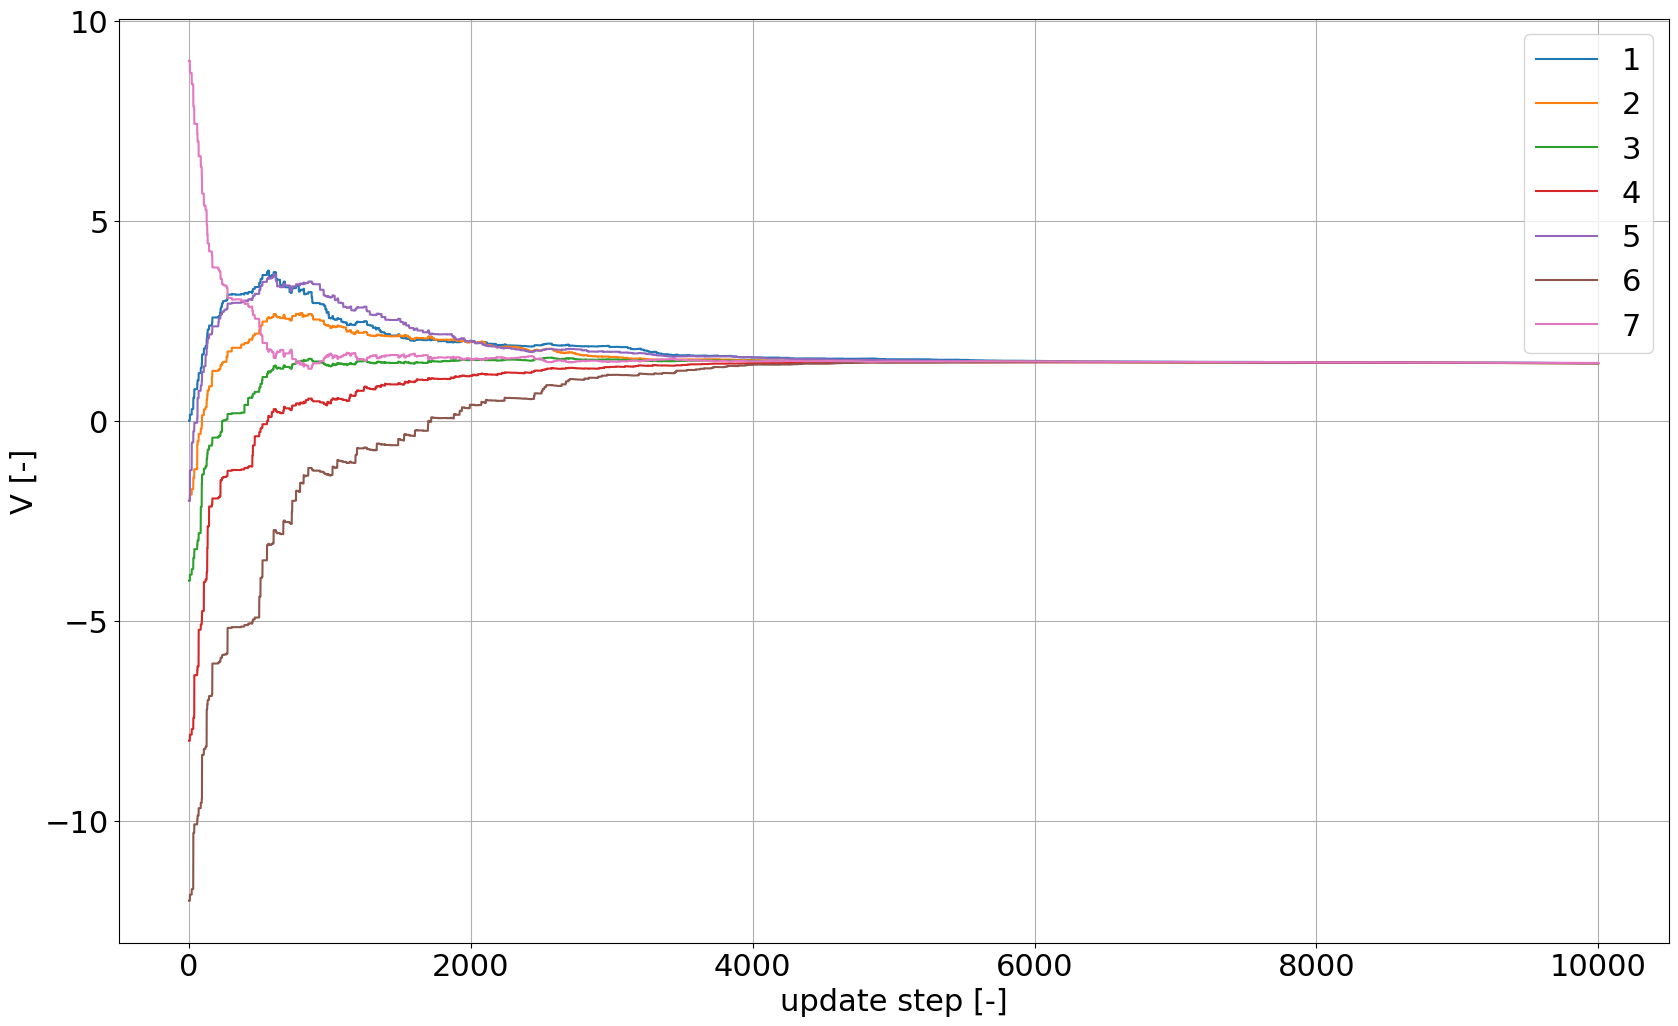

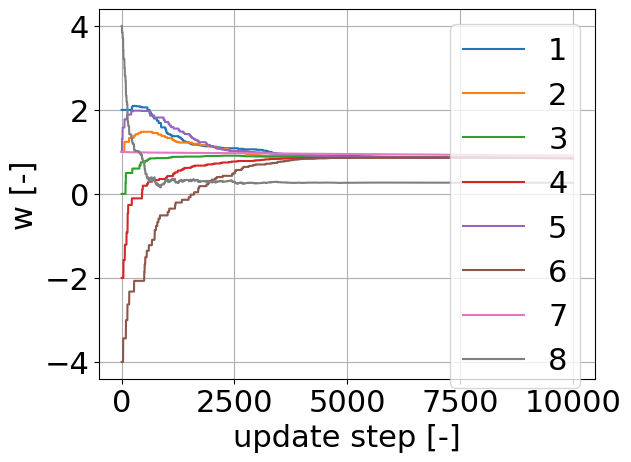

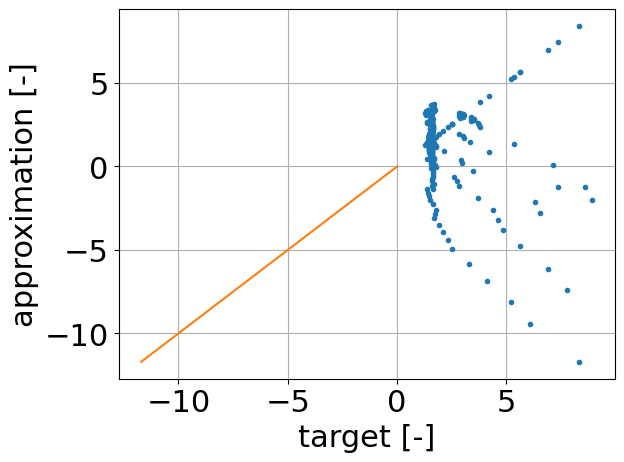

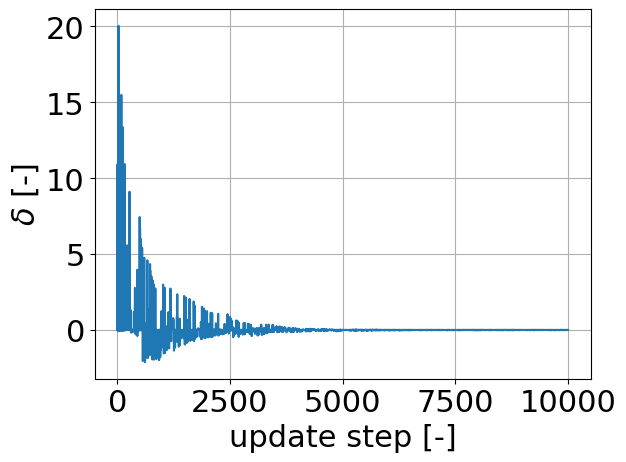

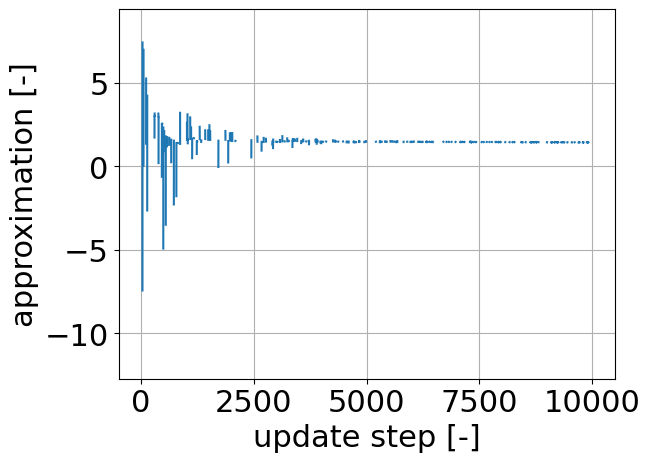

In [26]:
w, w_m, Dw8, target, approx, delta = SIGS[str(sim_index)]
plot_MDP(w, w_m, Dw8, target, approx, delta, PARS[str(sim_index)])

### 💭
- Reducing the stepsize does not improve the approximation accuracy (where it converges)

In [27]:
sim_index = 7 
PERFORMANCE_INDEX[str(sim_index)] = copyd(PERFORMANCE_INDEX_DEFAULT)
PERFORMANCE_INDEX[str(sim_index)]['sim'] = sim_index
PERFORMANCE_INDEX[str(sim_index)]['convergence_rate'] = ID__INDEX__CONVERGENCE_RATE__MEDIUM

PERFORMANCE_INDEX[str(sim_index)]['correlation between update and approximation'] =\
      ID__INDEX__CORRELATION_UPDATE_APPROX__ZERO
PERFORMANCE_INDEX[str(sim_index)]['approximation accuracy'] = ID__INDEX__APPROXIMATION_ACCURACY__LOW

## 8

In [28]:
sim_index = 8

PARS[str(sim_index)] = copyd(PARS[str(5)])
PARS[str(sim_index)]['sim'] = sim_index
PARS[str(sim_index)]['alpha'] = 0.07


SIGS[str(sim_index)] = run_MDP(PARS[str(sim_index)])

### Plots

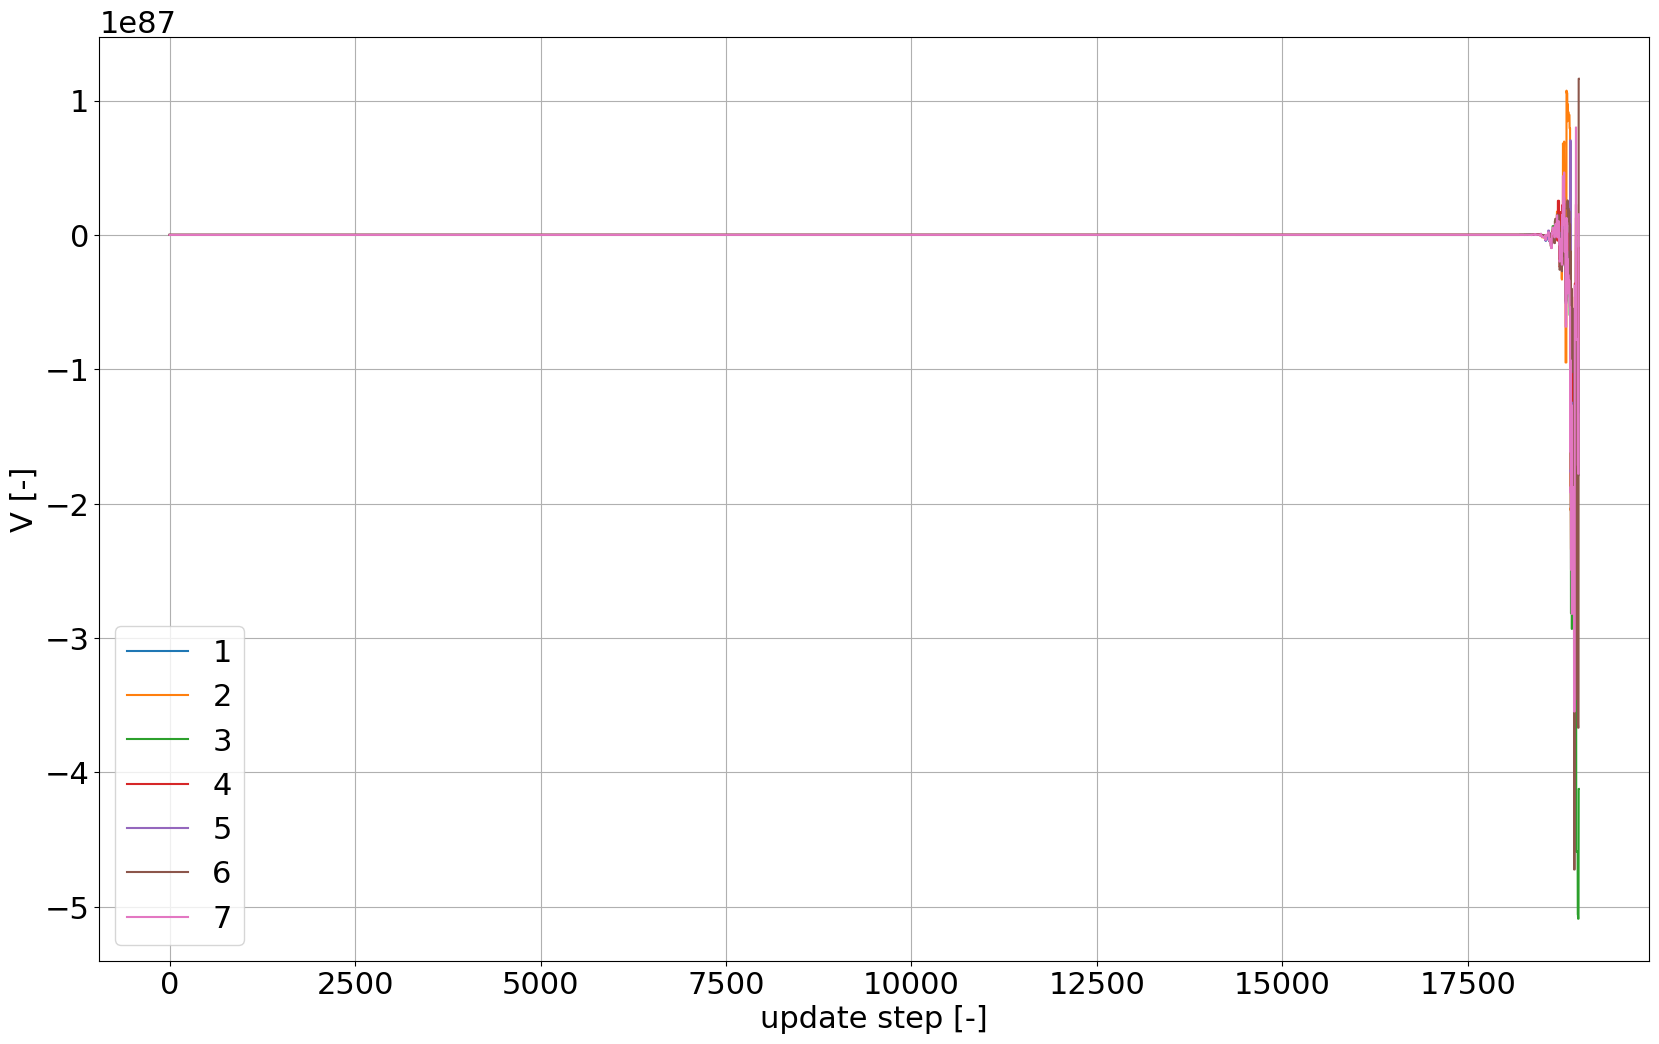

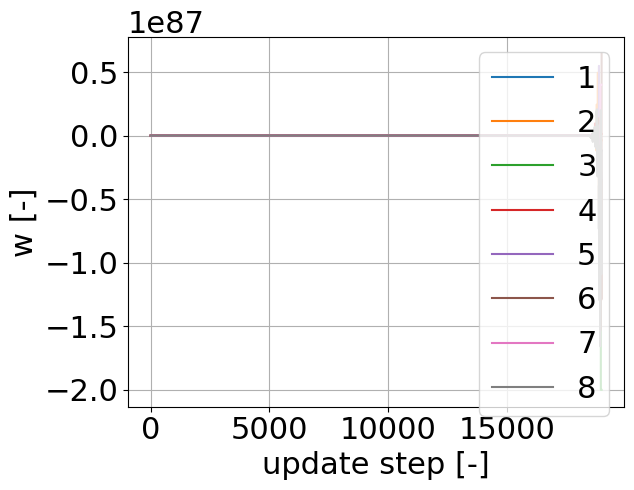

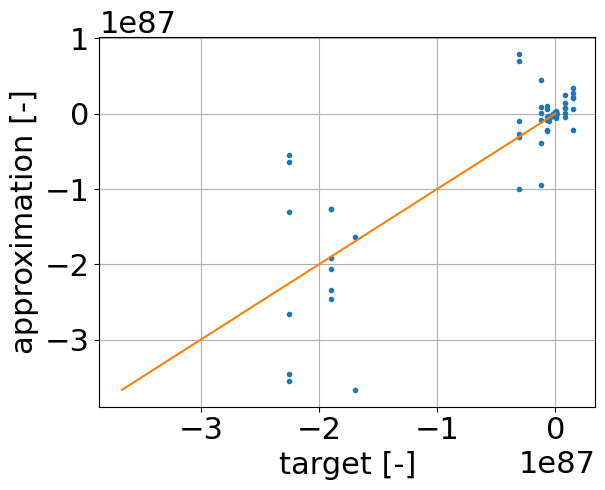

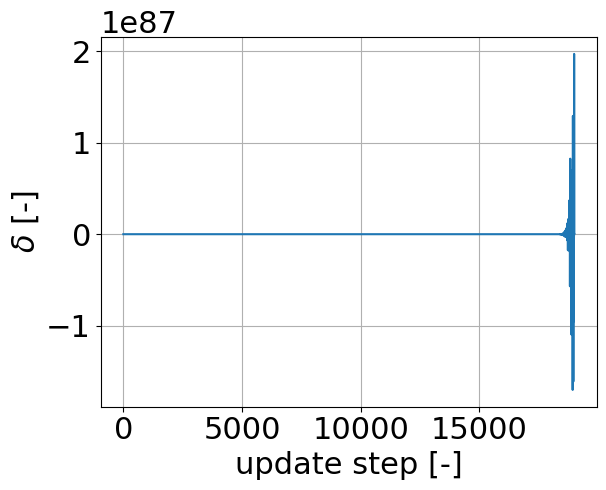

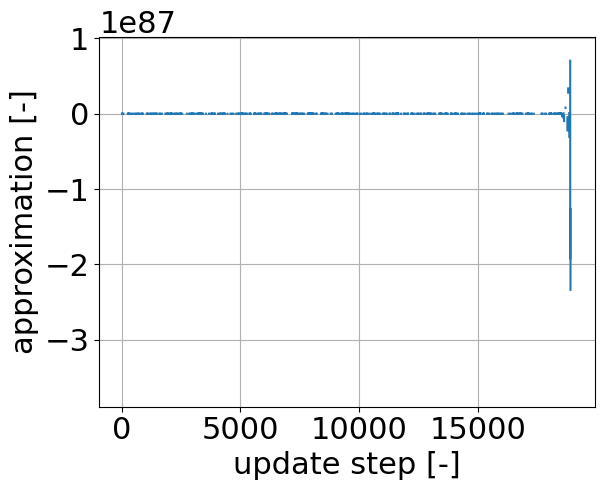

In [29]:
w, w_m, Dw8, target, approx, delta = SIGS[str(sim_index)]
plot_MDP(w, w_m, Dw8, target, approx, delta, PARS[str(sim_index)])

### 💭
- Reducing the stepsize does not improve the approximation accuracy (where it converges)

In [30]:
sim_index = 8
PERFORMANCE_INDEX[str(sim_index)] = copyd(PERFORMANCE_INDEX_DEFAULT)
PERFORMANCE_INDEX[str(sim_index)]['sim'] = sim_index
PERFORMANCE_INDEX[str(sim_index)]['convergence_rate'] = ID__INDEX__CONVERGENCE_RATE__DOES_NOT_CONVERGE

PERFORMANCE_INDEX[str(sim_index)]['correlation between update and approximation'] =\
      ID__INDEX__CORRELATION_UPDATE_APPROX__ZERO
PERFORMANCE_INDEX[str(sim_index)]['approximation accuracy'] = ID__INDEX__APPROXIMATION_ACCURACY__NOT_APPL

## 9 ⚠

In [31]:
sim_index = 9

PARS[str(sim_index)] = copyd(PARS[str(5)])
PARS[str(sim_index)]['sim'] = sim_index
PARS[str(sim_index)]['alpha'] = 0.01


SIGS[str(sim_index)] = run_MDP(PARS[str(sim_index)])

### Plots

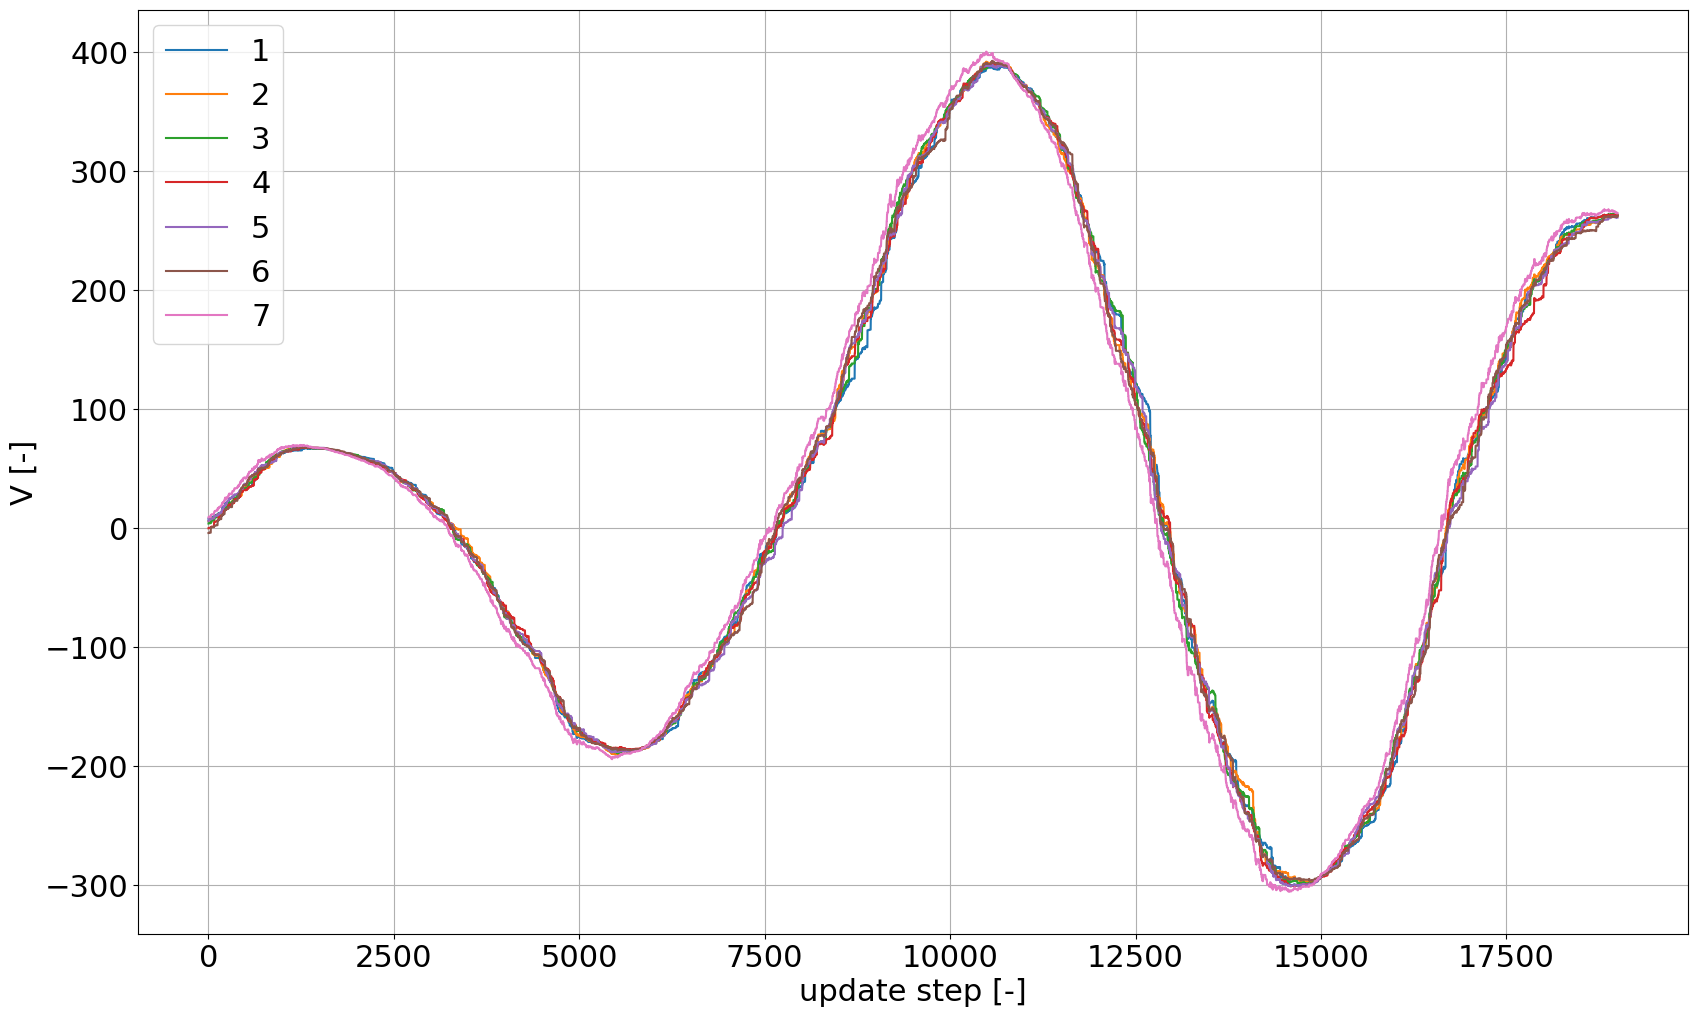

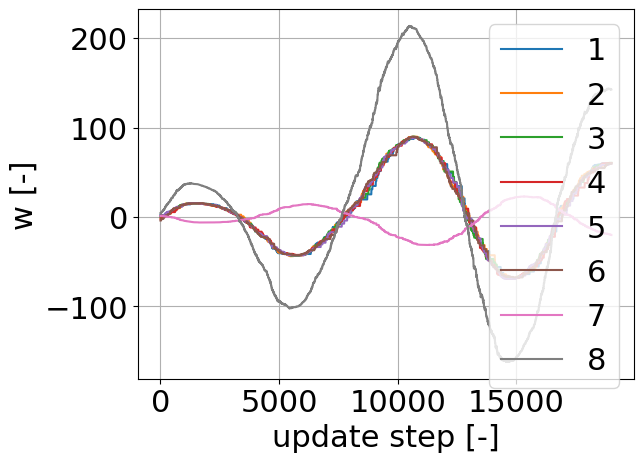

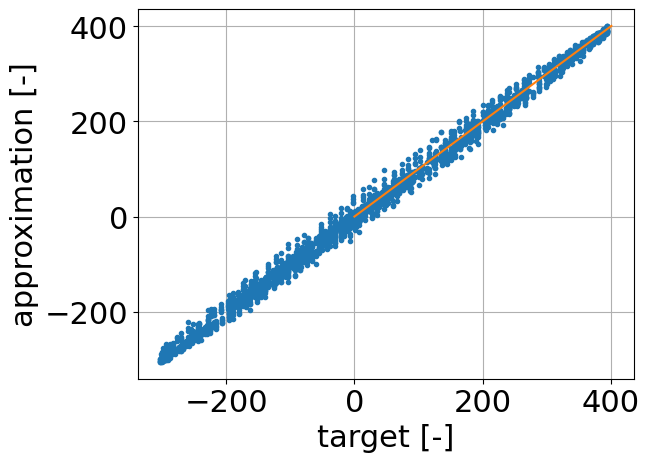

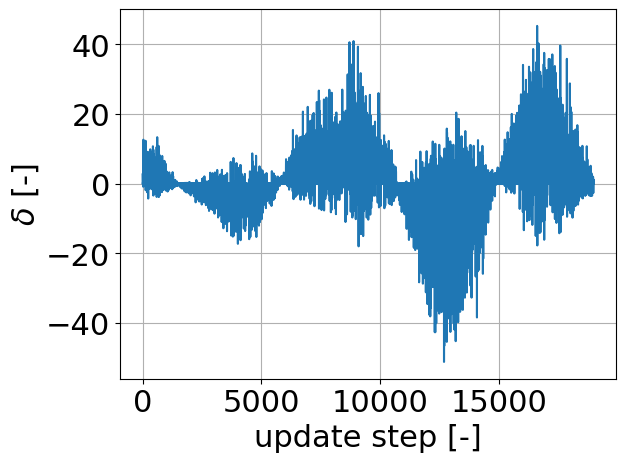

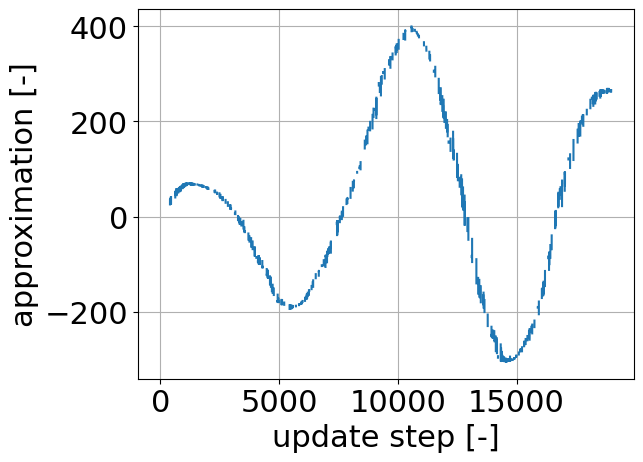

In [32]:
w, w_m, Dw8, target, approx, delta = SIGS[str(sim_index)]
plot_MDP(w, w_m, Dw8, target, approx, delta, PARS[str(sim_index)])

### 💭
- ⚠🤷‍♀️ How is it that reducing the step size generates worse results?

In [33]:
sim_index = 9
PERFORMANCE_INDEX[str(sim_index)] = copyd(PERFORMANCE_INDEX_DEFAULT)
PERFORMANCE_INDEX[str(sim_index)]['sim'] = str(sim_index) + ' ⚠'
PERFORMANCE_INDEX[str(sim_index)]['convergence_rate'] = ID__INDEX__CONVERGENCE_RATE__DOES_NOT_CONVERGE

PERFORMANCE_INDEX[str(sim_index)]['correlation between update and approximation'] =\
      ID__INDEX__CORRELATION_UPDATE_APPROX__HIGH
PERFORMANCE_INDEX[str(sim_index)]['approximation accuracy'] = ID__INDEX__APPROXIMATION_ACCURACY__NOT_APPL

## 10 ⚠

In [34]:
sim_index = 10

PARS[str(sim_index)] = copyd(PARS[str(5)])
PARS[str(sim_index)]['sim'] = sim_index
PARS[str(sim_index)]['alpha'] = 0.005
PARS[str(sim_index)]['N_iterations'] = 35000


SIGS[str(sim_index)] = run_MDP(PARS[str(sim_index)])

### Plots

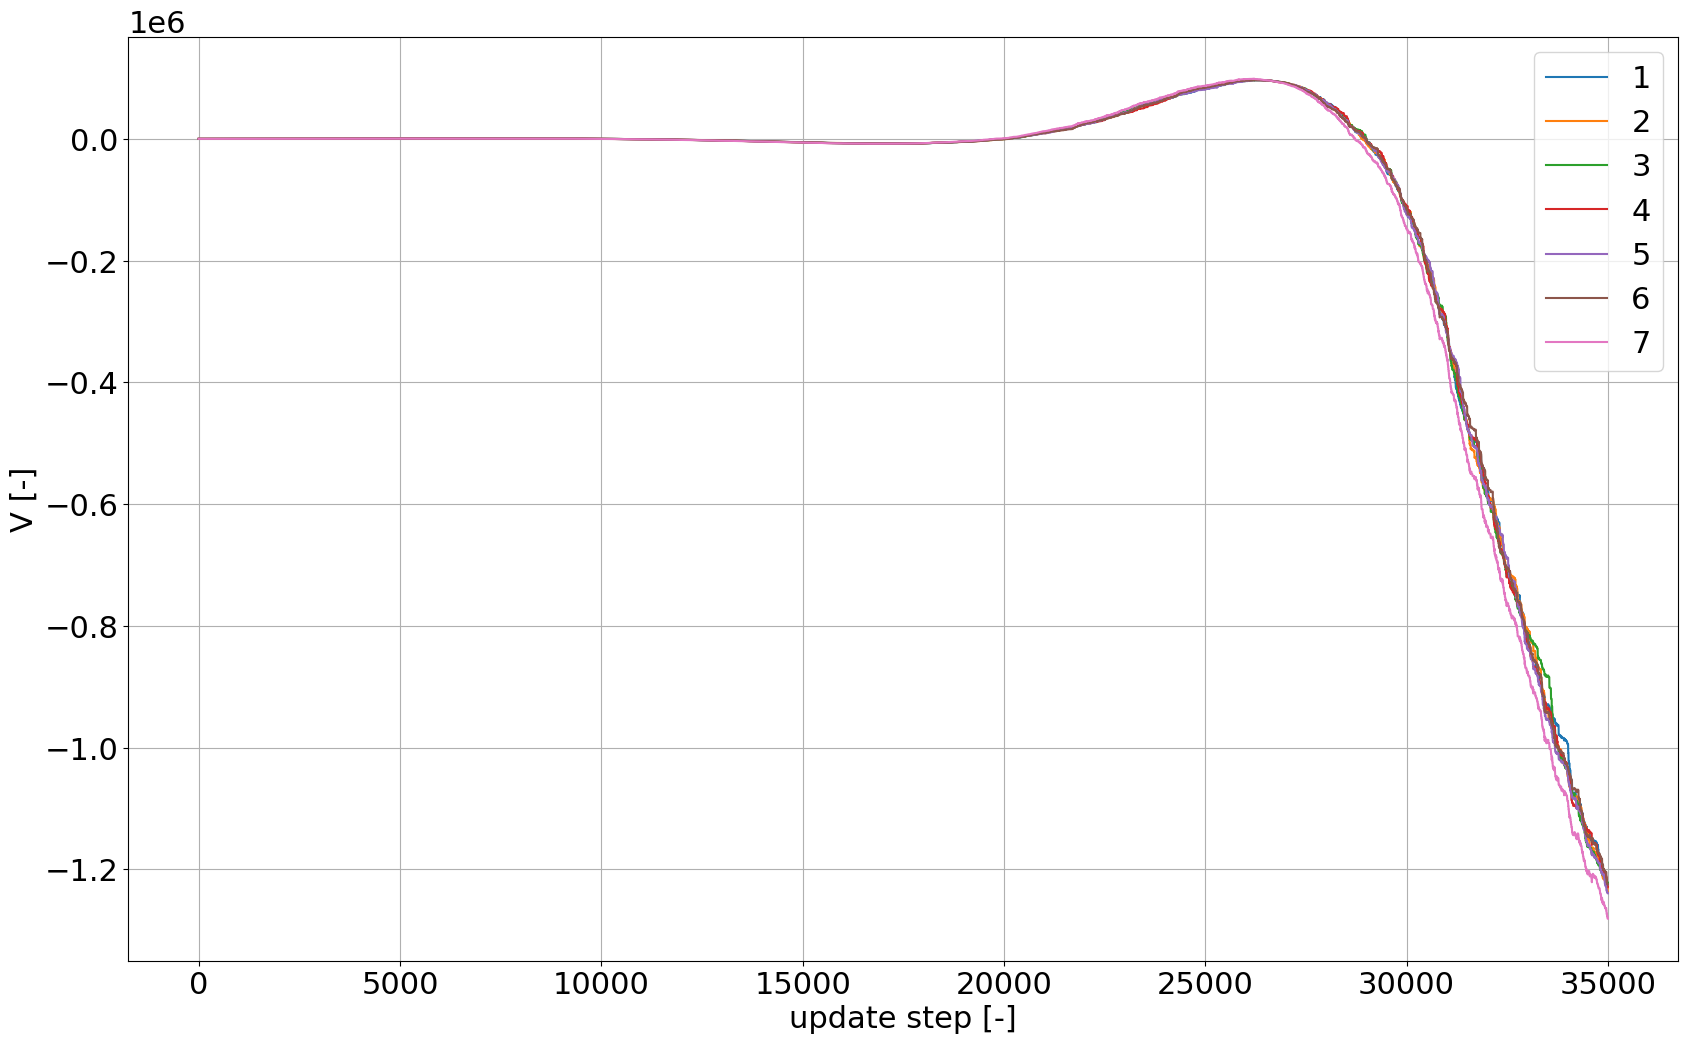

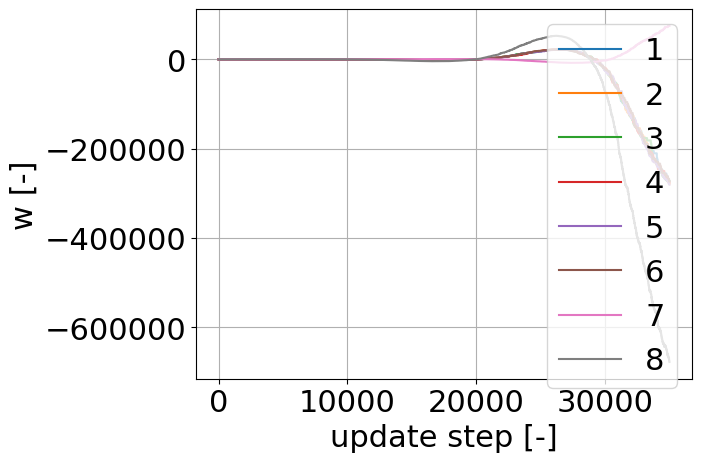

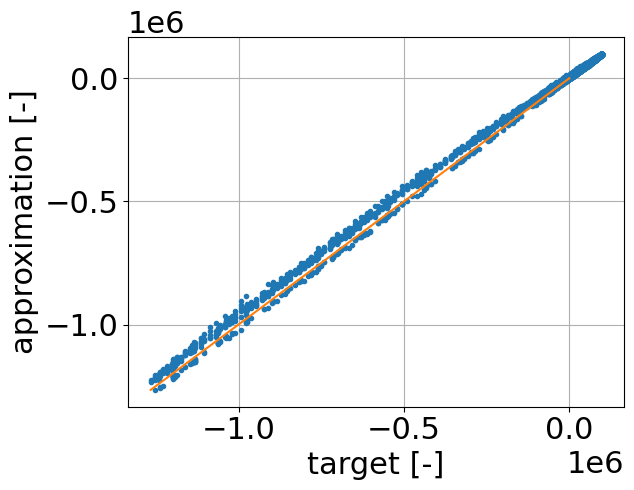

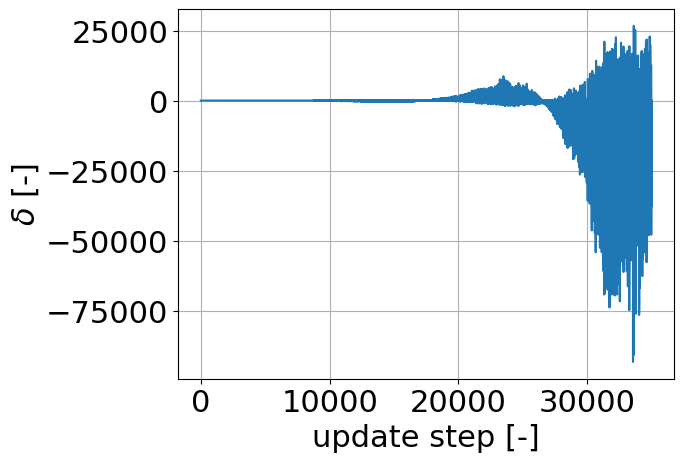

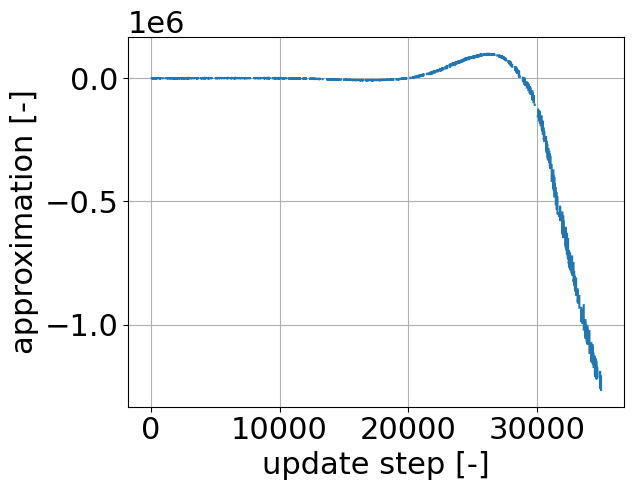

In [35]:
w, w_m, Dw8, target, approx, delta = SIGS[str(sim_index)]
plot_MDP(w, w_m, Dw8, target, approx, delta, PARS[str(sim_index)])

### 💭
- ⚠🤷‍♀️ How is it that reducing the step size generates worse results?

In [36]:
sim_index = 10
PERFORMANCE_INDEX[str(sim_index)] = copyd(PERFORMANCE_INDEX_DEFAULT)
PERFORMANCE_INDEX[str(sim_index)]['sim'] = str(sim_index) + ' ⚠'
PERFORMANCE_INDEX[str(sim_index)]['convergence_rate'] = ID__INDEX__CONVERGENCE_RATE__DOES_NOT_CONVERGE

PERFORMANCE_INDEX[str(sim_index)]['correlation between update and approximation'] =\
      ID__INDEX__CORRELATION_UPDATE_APPROX__HIGH
PERFORMANCE_INDEX[str(sim_index)]['approximation accuracy'] = ID__INDEX__APPROXIMATION_ACCURACY__NOT_APPL

## 11

In [37]:
sim_index = 11

PARS[str(sim_index)] = copyd(PARS[str(5)])
PARS[str(sim_index)]['sim'] = sim_index
PARS[str(sim_index)]['alpha'] = 0.012
PARS[str(sim_index)]['N_iterations'] = 35000

SIGS[str(sim_index)] = run_MDP(PARS[str(sim_index)])

### Plots

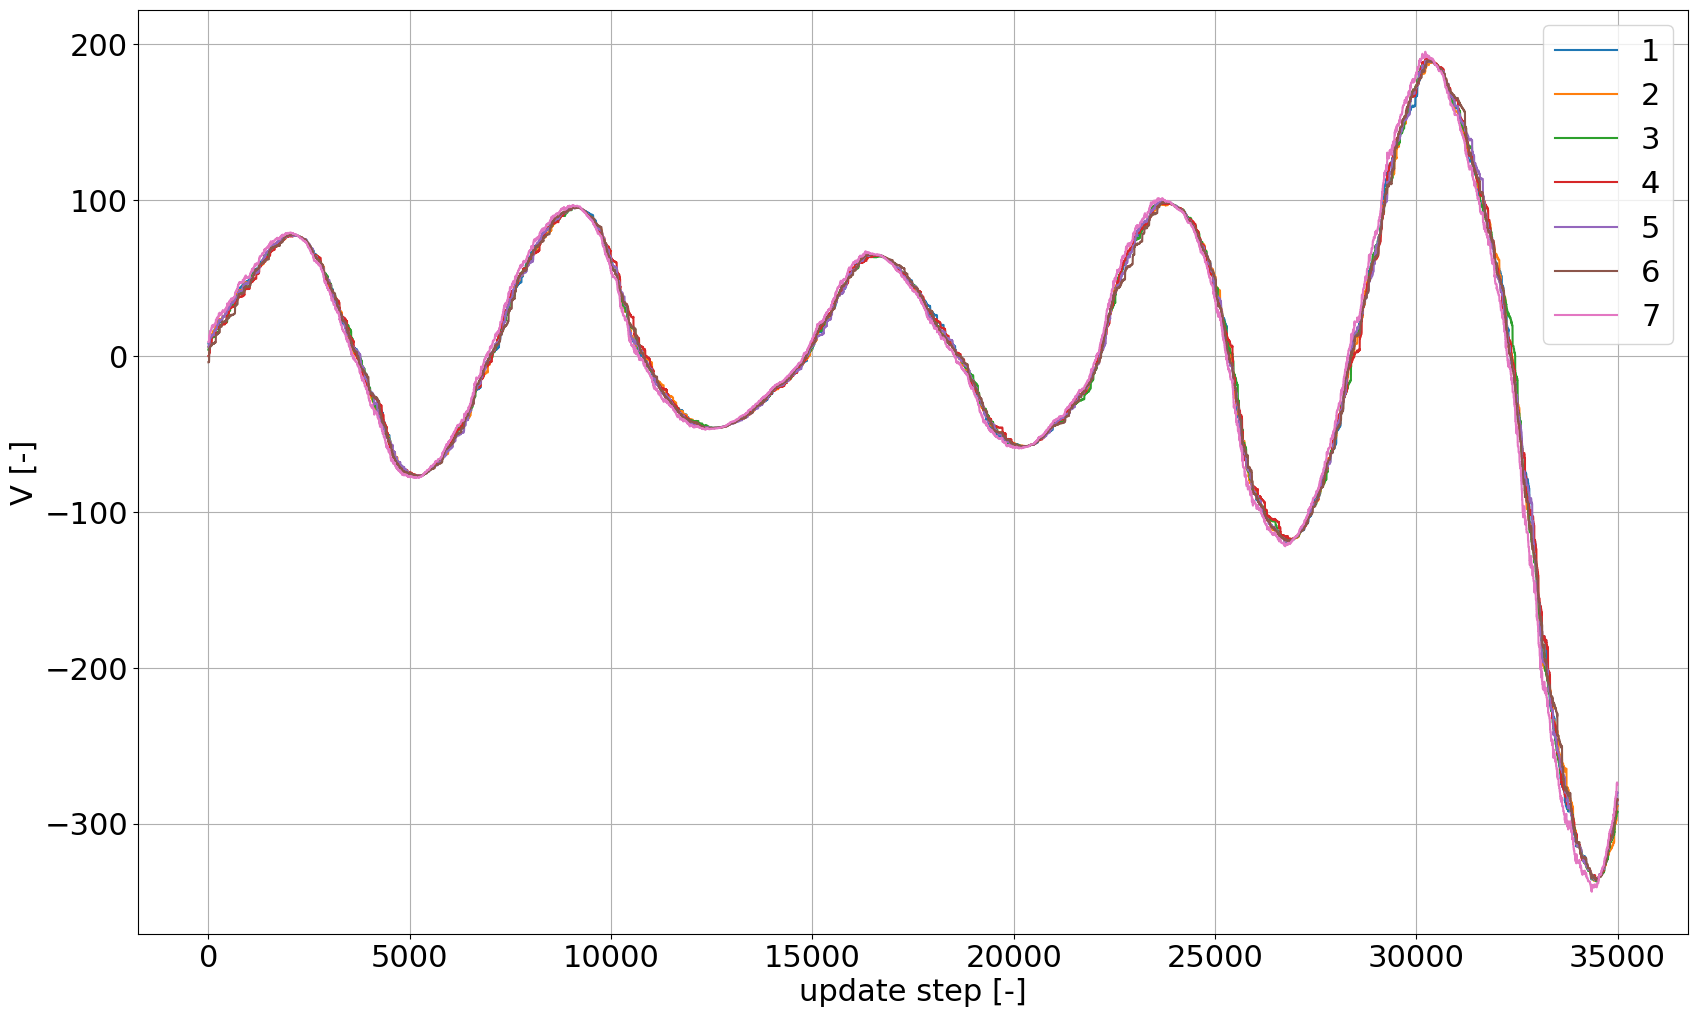

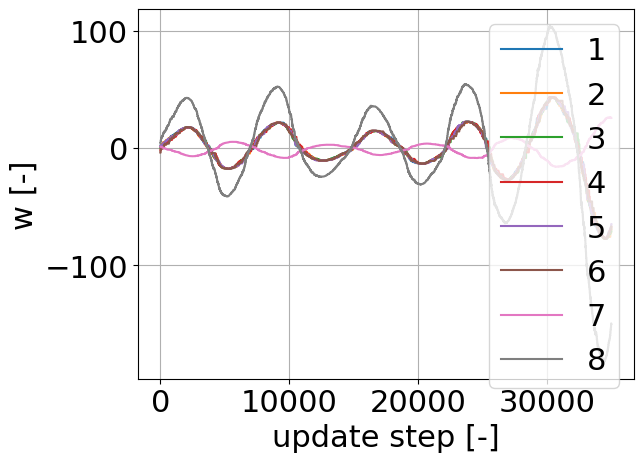

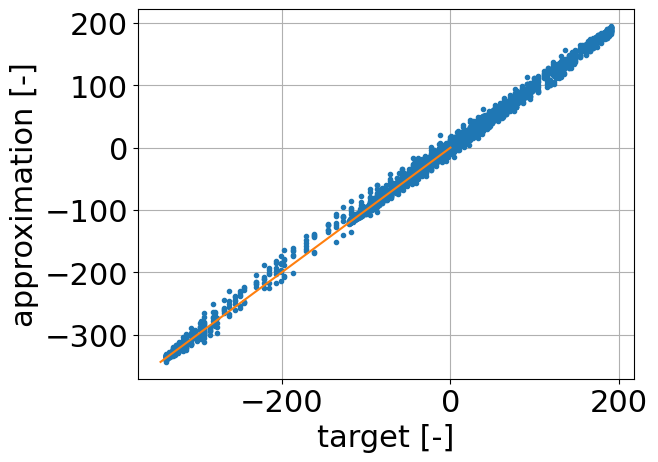

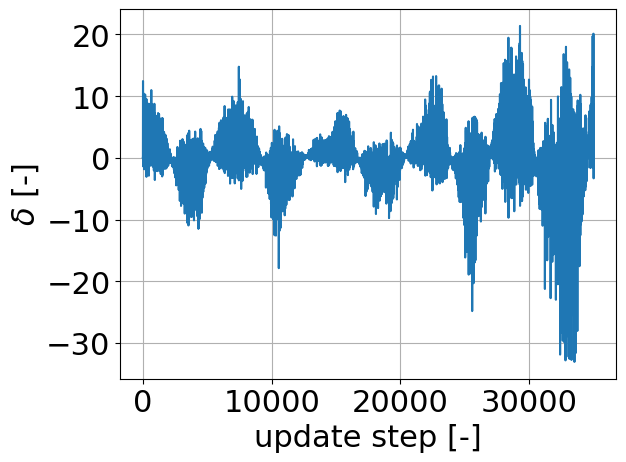

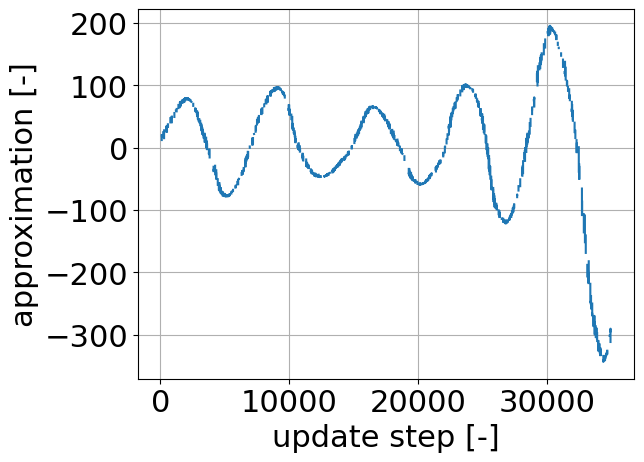

In [38]:
w, w_m, Dw8, target, approx, delta = SIGS[str(sim_index)]
plot_MDP(w, w_m, Dw8, target, approx, delta, PARS[str(sim_index)])

### 💭
- Getting stabilized --> finding a "sweet spot"

In [39]:
sim_index = 11
PERFORMANCE_INDEX[str(sim_index)] = copyd(PERFORMANCE_INDEX_DEFAULT)
PERFORMANCE_INDEX[str(sim_index)]['sim'] = str(sim_index)
PERFORMANCE_INDEX[str(sim_index)]['convergence_rate'] = ID__INDEX__CONVERGENCE_RATE__EXTREMELY_LOW

PERFORMANCE_INDEX[str(sim_index)]['correlation between update and approximation'] =\
      ID__INDEX__CORRELATION_UPDATE_APPROX__HIGH
PERFORMANCE_INDEX[str(sim_index)]['approximation accuracy'] = ID__INDEX__APPROXIMATION_ACCURACY__LOW

## 12

In [40]:
sim_index = 12

PARS[str(sim_index)] = copyd(PARS[str(7)])
PARS[str(sim_index)]['sim'] = sim_index
PARS[str(sim_index)]['b'] = np.array([1/2, 1/2])

SIGS[str(sim_index)] = run_MDP(PARS[str(sim_index)])

### Plots

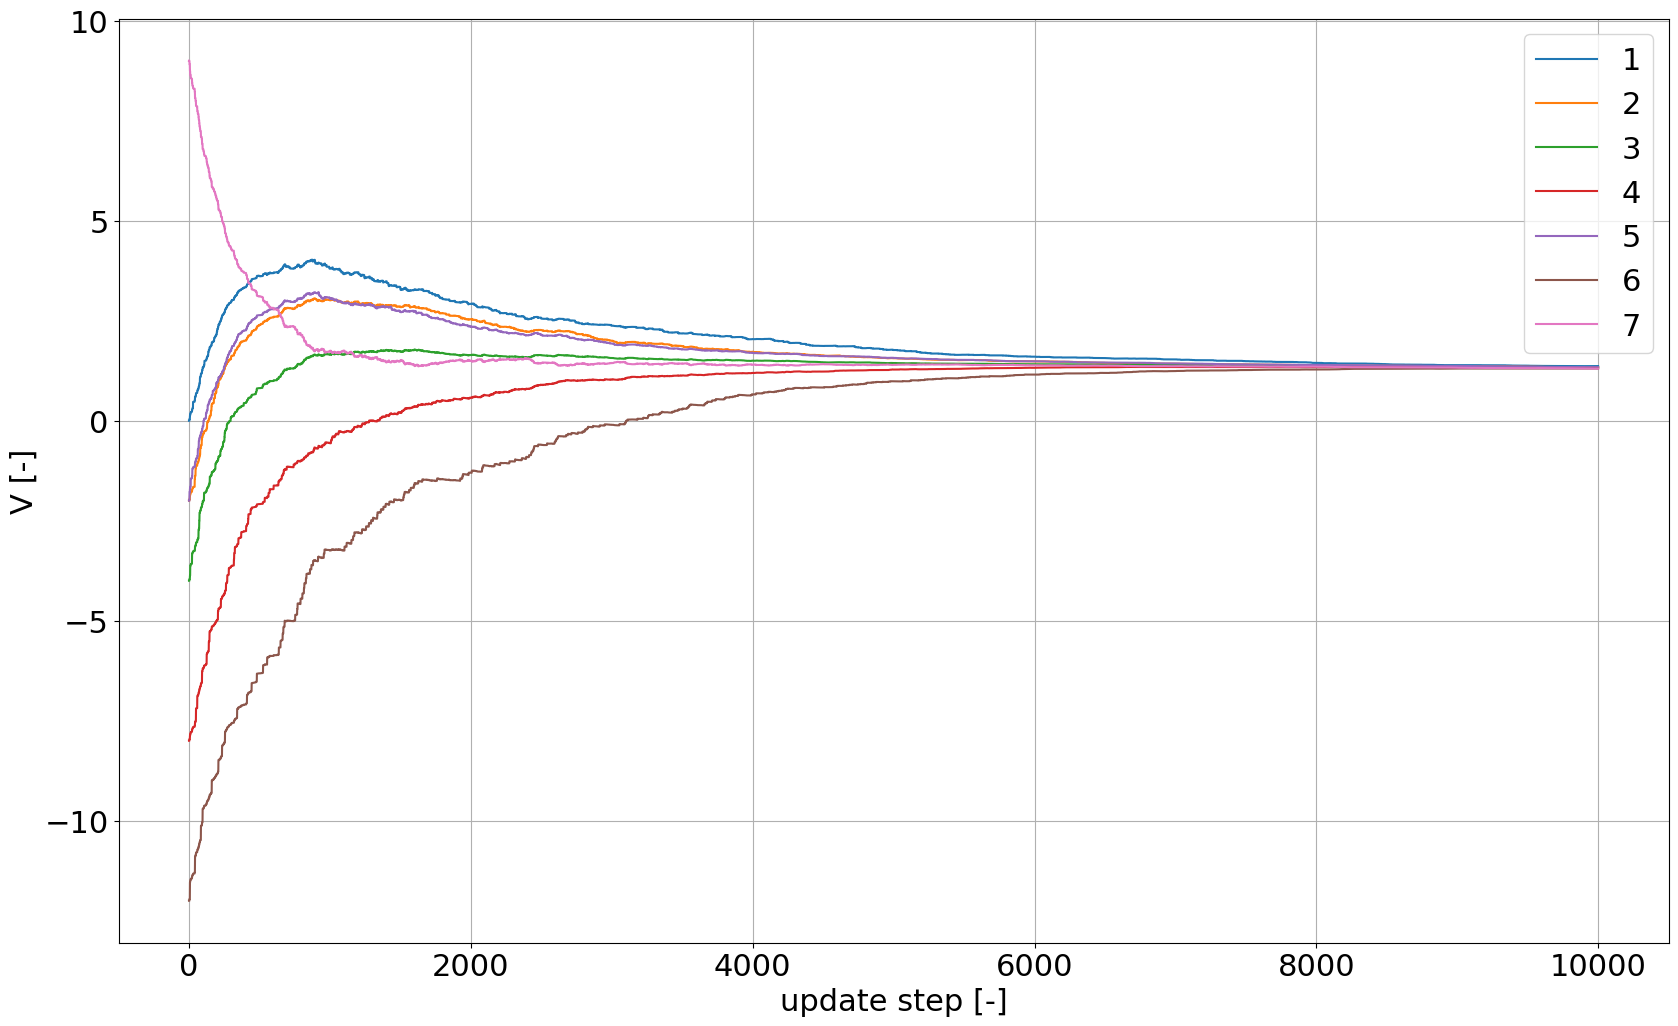

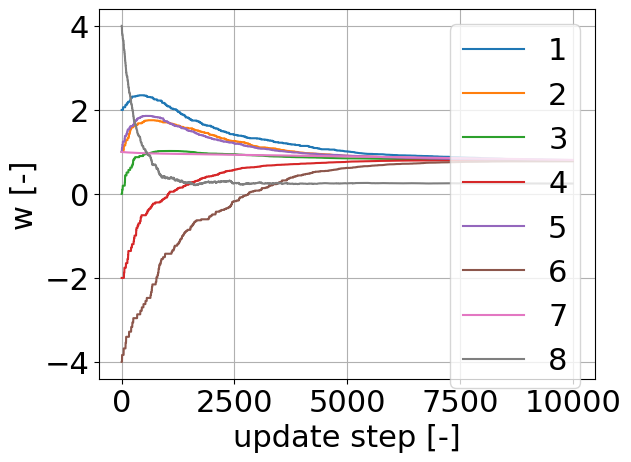

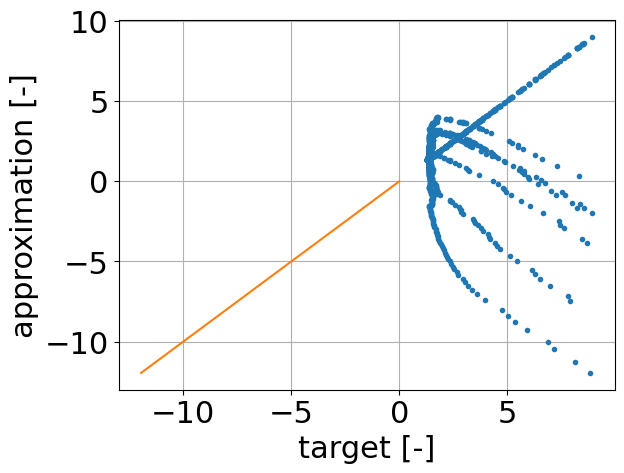

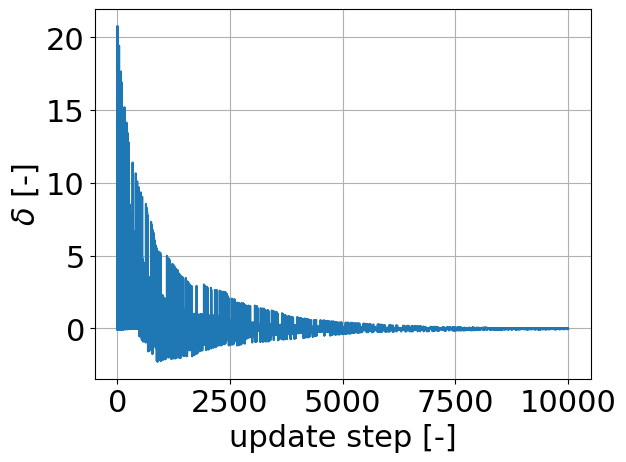

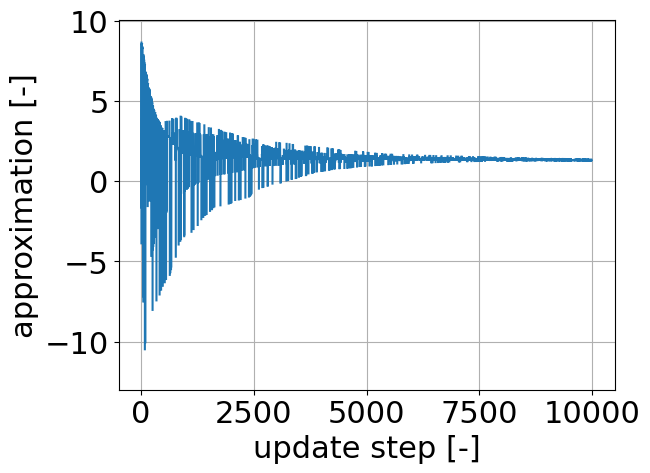

In [41]:
w, w_m, Dw8, target, approx, delta = SIGS[str(sim_index)]
plot_MDP(w, w_m, Dw8, target, approx, delta, PARS[str(sim_index)])

### 💭
- Getting stabilized --> finding a "sweet spot"

In [42]:
sim_index = 12
PERFORMANCE_INDEX[str(sim_index)] = copyd(PERFORMANCE_INDEX_DEFAULT)
PERFORMANCE_INDEX[str(sim_index)]['sim'] = str(sim_index)
PERFORMANCE_INDEX[str(sim_index)]['convergence_rate'] = ID__INDEX__CONVERGENCE_RATE__LOW

PERFORMANCE_INDEX[str(sim_index)]['correlation between update and approximation'] =\
      ID__INDEX__CORRELATION_UPDATE_APPROX__ZERO
PERFORMANCE_INDEX[str(sim_index)]['approximation accuracy'] = ID__INDEX__APPROXIMATION_ACCURACY__LOW

# Overall

## Parameter Table

In [50]:
print_table(PARS)

| sim|N_iterations|gamma|alpha|K |               w0                |           b           | pi  |p8|                    plot                     |                                                                                              X                                                                                               |
|---|------------|-----|-----|--|---------------------------------|-----------------------|-----|--|---------------------------------------------|---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
 1  |    19000     | 0.99  | 0.02  | 12 | [ 2.  1.  0. -2.  1. -4.  1.  4.] | [0.14285714 0.85714286] | [1 0] | 1  |                                [[2 0 0 0 0 0 0 1] [0 2 0 0 0 0 0 1] [0 0 2 0 0 0 0 1] [0 0 0 2 0 0 0 1] [0 0 0 0 2 0 0 1] [0 0 0 0 0 2 0 1] [0 0 0 0 0 0 1 2]]                                | 
 2  |    10000

## Performance Index Table

In [51]:
print_table(PERFORMANCE_INDEX)

| sim |convergence_rate|correlation between update and approximation|approximation accuracy |
|----|----------------|--------------------------------------------|----------------------|
 1   |       Low        |                     High                     |          High          | 
 2   |  No Convergence  |                     High                     |          N/A           | 
 3   |       High       |                      0                       |          Low           | 
 4   |       Low        |                      ?                       |          High          | 
 5   |       High       |                     High                     |          High          | 
 6   |  No Convergence  |                     High                     |          N/A           | 
 7   |      Medium      |                      0                       |          Low           | 
 8   |  No Convergence  |                      0                       |          N/A           | 
9 ⚠  |  No Convergence